### Kaggle Competition:

# Histopathologic Cancer Detection

### solution: Georg Sommer 

https://www.kaggle.com/c/histopathologic-cancer-detection
<img src="index.jpeg" width="745" height="154" align="left"/>


# The Task

Binary image classification: 220,000 labeled microscopic images(96x96 pixels) of lymph node tissue are provided in the train set and about 57,000 in the test set. 

The task ist to determine if the images show metastatic cancer tissue in the 32x32 center region of the image. One key challenge is that the metastases can be as small as single cells in a large area of tissue.

For in depht informartion on the topic:
https://www.nature.com/articles/nmeth.4397.pdf

Tested on: Razor Blade 15, linux ubuntu 19.04, CPU: Intel Core i7,8750h, GPU: nvidia gtx1070 (8GB VRAM), RAM: 64GB (or lower the IMAGE-INPUT)

# Imports

In [1]:
import numpy as np
import pandas as pd
import cv2
import os
from glob import glob
from tqdm import tqdm_notebook, trange

from sklearn.model_selection import train_test_split
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras.utils import to_categorical

import keras.backend as K
from keras.models import Sequential, Model, load_model
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D
from keras.layers import Activation, BatchNormalization,  Dropout, Flatten, Dense, Input, Add
from keras.losses import binary_crossentropy, categorical_crossentropy
from keras.optimizers import RMSprop, Adam, SGD, Adagrad
from keras.applications import InceptionResNetV2, NASNetLarge
from keras.callbacks import CSVLogger, TensorBoard, ModelCheckpoint, ReduceLROnPlateau, EarlyStopping, LearningRateScheduler

from PIL import Image
from pandas_ml import ConfusionMatrix
import gc

import matplotlib.pyplot as plt
%matplotlib inline


Using TensorFlow backend.


In [2]:
# GPU available?
import tensorflow as tf

tf.test.is_gpu_available(
    cuda_only=False,
    min_cuda_compute_capability=None)


True

# Load the Labels and Filenames

In [3]:
# paths of training and test data
path = "./data/" # path of current directory.../data/
train_path = path + 'train/'
test_path = path + 'test/'

# glob finds the pathnames matching a specified pattern(-here all tif-files in ./data/train)
# create dataframe w. column 'path' w. the pathes of all the files in './data/train/' that end with '.tif' (*=no matter whats before .tif)
df = pd.DataFrame({'path': glob(os.path.join(train_path, '*.tif'))})  # load the filenames


# the map() function applies a given function to each item of an iterable (list, tuple etc.) here to df.path
# and returns a list of the results
# split the filepath at the '/' and take part[3]
# split the part[3] at the (".") and take part [0] (the id/filenames)
# create new column 'id' with id/filenames
df['id'] = df.path.map(lambda x: x.split('/')[3].split(".")[0])

# create dataframe labels out of the "train_labels.csv" (id and labels are automatically separated in diff. columns)
labels = pd.read_csv(path+"train_labels.csv")

# merge df and labels on(column)="id" (#in the order of df)
df = df.merge(labels, on="id")

df.head(10)  # print the first entrys


path  \
0  ./data/train/9409901458bbb46941d1eac4e04b122d7...   
1  ./data/train/ca33287483ad968f1f955ae8af232ca2f...   
2  ./data/train/4e88b246dd2f7e55d2dad8711e3f49f30...   
3  ./data/train/409c141ab6ef2dfd08c179e13ab3a65fd...   
4  ./data/train/1760eba0c4499bbaf1672075b13193c77...   
5  ./data/train/b65d4eb7836694ec19fcd76c23ac4f439...   
6  ./data/train/4de3c4c3e6e2de69746f8421ef61e58bb...   
7  ./data/train/de9c44f6c05de252dae0dd469f64f9edf...   
8  ./data/train/9a9b10bf1ec0b51a6380d05b7b100c613...   
9  ./data/train/f5ec7e555ca812472a23c826318008e9e...   

                                         id  label  
0  9409901458bbb46941d1eac4e04b122d74dce7c5      1  
1  ca33287483ad968f1f955ae8af232ca2fc0d113d      1  
2  4e88b246dd2f7e55d2dad8711e3f49f30ae78020      1  
3  409c141ab6ef2dfd08c179e13ab3a65fd6cee983      0  
4  1760eba0c4499bbaf1672075b13193c778a464e9      1  
5  b65d4eb7836694ec19fcd76c23ac4f43994d1a59      1  
6  4de3c4c3e6e2de69746f8421ef61e58bb3a3c2fa      0  
7  de9c44f6c05de252dae0dd469f64f9edf8e436b2      1  
8  9a9b10bf1ec0b51a6380d05b7b100c61326ea6b9      1  
9  f5ec7e555ca812472a23c826318008e9e7537d8b      1

# Load the Images


In [4]:
def load_data(N, df):
    """ This functions loads N images using the data df
    """
    # create a numpy array (w. zeros) for the images (N, 96x96px, 3 channels, values 0 - 255)
    X = np.zeros([N, 96, 96, 3], dtype=np.uint8) # because image info is 0-255 uint8=8bit is perfect 

    # convert the labels to a numpy array columns=['label'] but only number 0 to N [0:N]
    y = np.squeeze(df.as_matrix(columns=['label']))[0:N]

    # read images one by one, tdqm notebook displays a progress bar
    for i, row in tqdm_notebook(df.iterrows(), total=N):
        if i == N:
            break
        # insert image by image to X - use cv2 to read images 
        X[i] = cv2.imread(row['path'])

    return X, y


In [5]:
# Load N images for a quick demo
N = 2000 #500

# or Load all images
# N = df["path"].size # get the number of images in the training data set

X, y = load_data(N=N, df=df)


/home/georg/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


In [6]:
X.shape

(2000, 96, 96, 3)

In [7]:
X

array([[[[174,  86, 170],
         [156,  66, 149],
         [143,  52, 131],
         ...,
         [131,  46,  96],
         [223, 139, 203],
         [152,  71, 144]],

        [[162,  72, 161],
         [180,  91, 177],
         [159,  66, 151],
         ...,
         [119,  33,  75],
         [122,  35,  91],
         [231, 145, 209]],

        [[185,  89, 183],
         [164,  71, 162],
         [164,  72, 161],
         ...,
         [ 92,   5,  39],
         [121,  32,  76],
         [168,  76, 129]],

        ...,

        [[160,  71, 145],
         [143,  52, 127],
         [154,  59, 133],
         ...,
         [148,  49, 105],
         [155,  54, 122],
         [174,  74, 150]],

        [[200, 108, 179],
         [168,  72, 142],
         [143,  45, 115],
         ...,
         [162,  67, 124],
         [183,  89, 154],
         [186,  91, 165]],

        [[166,  71, 138],
         [146,  49, 116],
         [156,  55, 123],
         ...,
         [195, 101, 160],
        

In [8]:
y.shape

(2000,)

In [9]:
y

array([1, 1, 1, ..., 0, 1, 0])

# EDA - Exploratory Data Analysis 


a few example images with labels (0=negative, 1=positive):

Label: 0


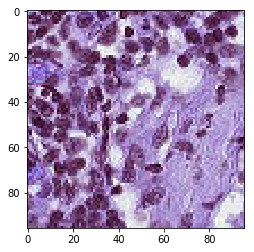

In [10]:
# sample nr. 99

print("Label:", y[99])
plt.imshow(X[99])

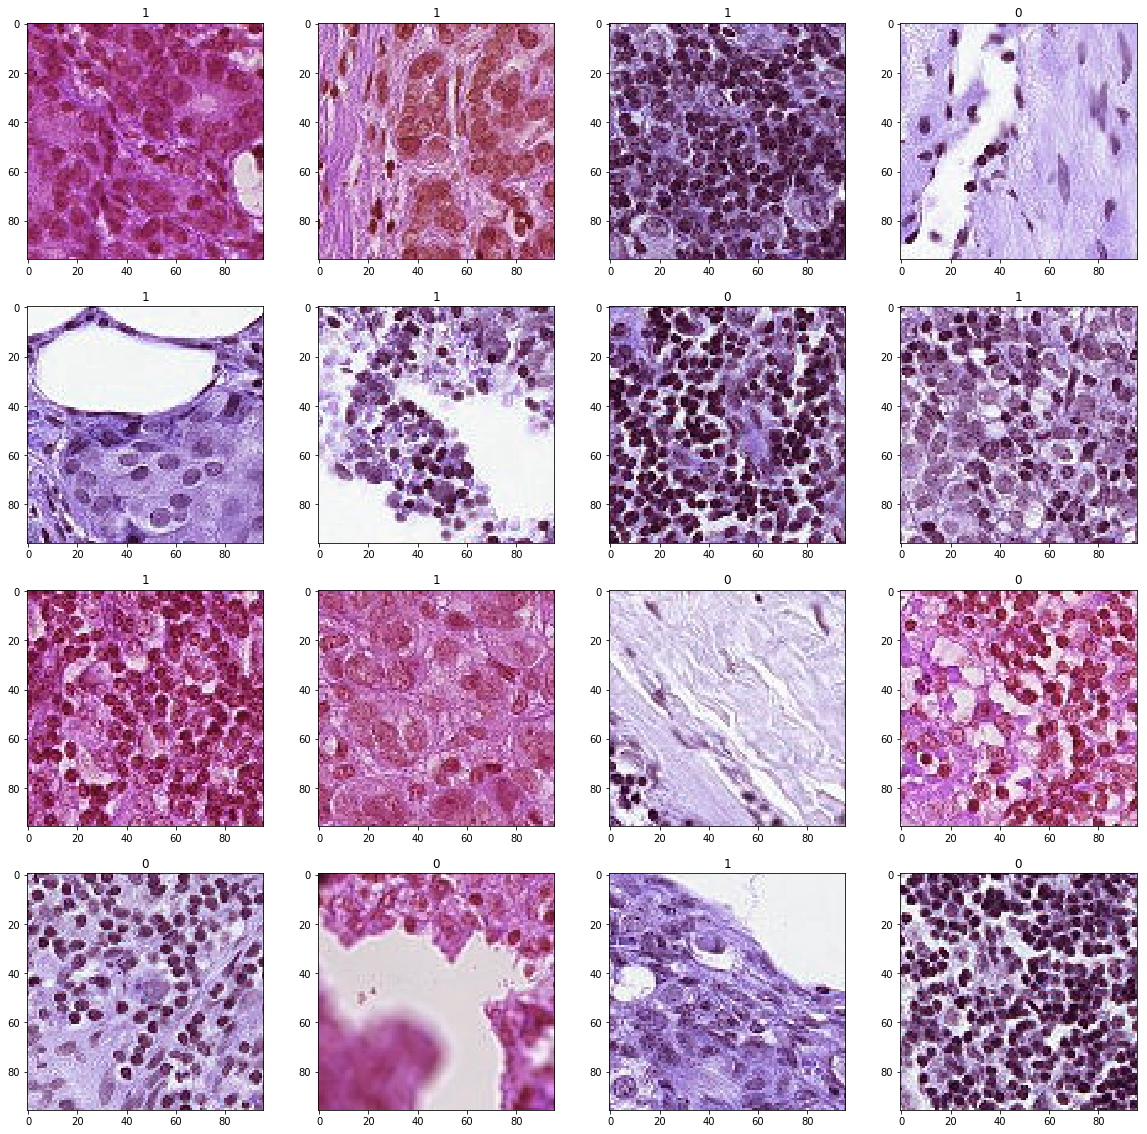

In [11]:
# show the first 16 samples

def show_samples(X,y):
    plt.figure(figsize=(20, 20))
    for i in range(0, 16):
        plt.subplot(4, 4, i + 1)
        plt.imshow(X[i])
        plt.title(y[i])
    plt.show()

show_samples(X,y)

conlusion: looks like there is no easy way to detect which images contain cancer cells 

#  Data Distribution

Text(0, 0.5, 'samples')

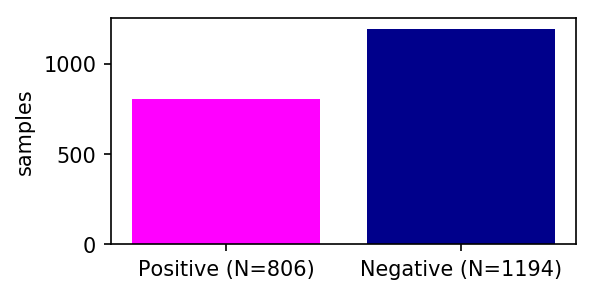

In [12]:
fig = plt.figure(figsize=(4, 2), dpi=150)
plt.bar([1,0], [(y == 0).sum(), (y == 1).sum()], color=["darkblue", "magenta"]); # plot a bar chart of the label frequency
plt.xticks([1,0], ["Negative (N={})".format((y == 0).sum()),"Positive (N={})".format((y == 1).sum())]);
plt.ylabel("samples")


In [13]:
positive_samples = X[y == 1]
negative_samples = X[y == 0]

# Distribution of Mean Image Brightness 

distribution o. mean image pixel values i.e. mean of each individual image 

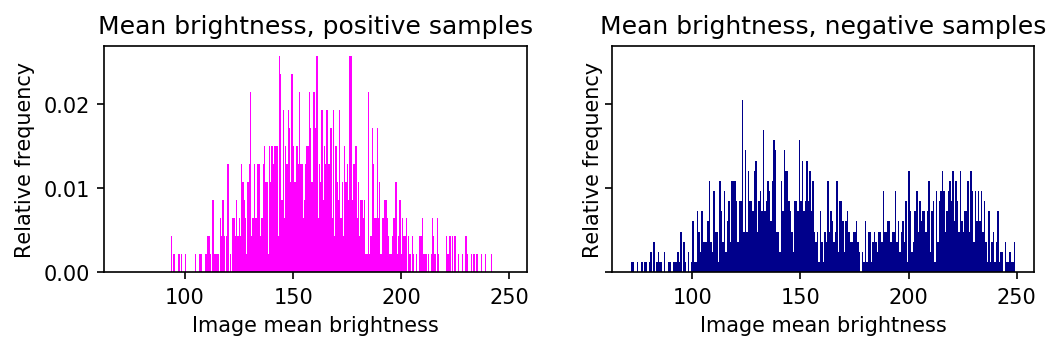

In [14]:
nr_of_bins = 256 
fig,axs = plt.subplots(1,2,sharey=True, sharex = True, figsize=(8,2),dpi=150)
axs[0].hist(np.mean(positive_samples,axis=(1,2,3)),bins=nr_of_bins,density=True, color= 'magenta');
axs[1].hist(np.mean(negative_samples,axis=(1,2,3)),bins=nr_of_bins,density=True, color= 'darkblue');
axs[0].set_title("Mean brightness, positive samples");
axs[1].set_title("Mean brightness, negative samples");
axs[0].set_xlabel("Image mean brightness")
axs[1].set_xlabel("Image mean brightness")
axs[0].set_ylabel("Relative frequency")
axs[1].set_ylabel("Relative frequency");

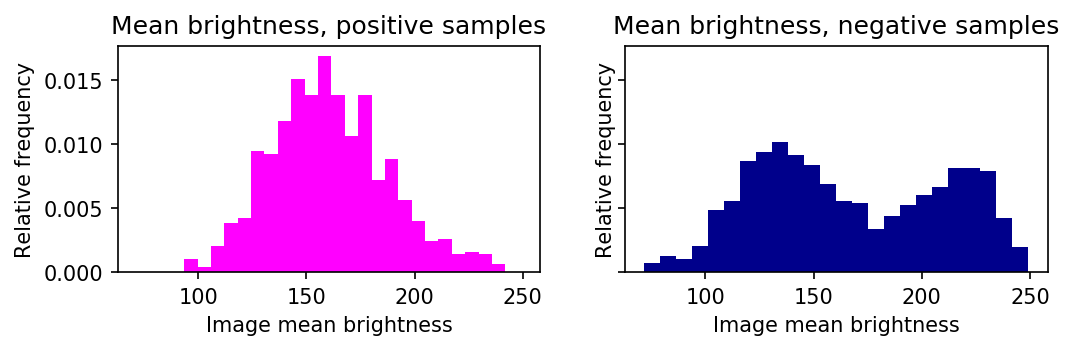

In [15]:
#difference positive/negative more obvious w. fewer bins 

nr_of_bins = 24 
fig,axs = plt.subplots(1,2,sharey=True, sharex = True, figsize=(8,2),dpi=150)
axs[0].hist(np.mean(positive_samples,axis=(1,2,3)),bins=nr_of_bins,density=True, color= 'magenta');
axs[1].hist(np.mean(negative_samples,axis=(1,2,3)),bins=nr_of_bins,density=True, color= 'darkblue');
axs[0].set_title("Mean brightness, positive samples");
axs[1].set_title("Mean brightness, negative samples");
axs[0].set_xlabel("Image mean brightness")
axs[1].set_xlabel("Image mean brightness")
axs[0].set_ylabel("Relative frequency")
axs[1].set_ylabel("Relative frequency");


conclusion: obvious difference between the positive and negative samples: 

* the distribution of mean brightness for the positive samples looks almost like a normal distribution around a brightness of 150 but the negative samples seem to follow bimodal distribution with peaks around 140 and 225. 

* there are about 50% more negative than positive samples. This might require adjustments to optimize the accuracy.

# Distribution of Average Pixel Values for each color channel 

i.e. averaging over all pixel values in the positive and negative samples

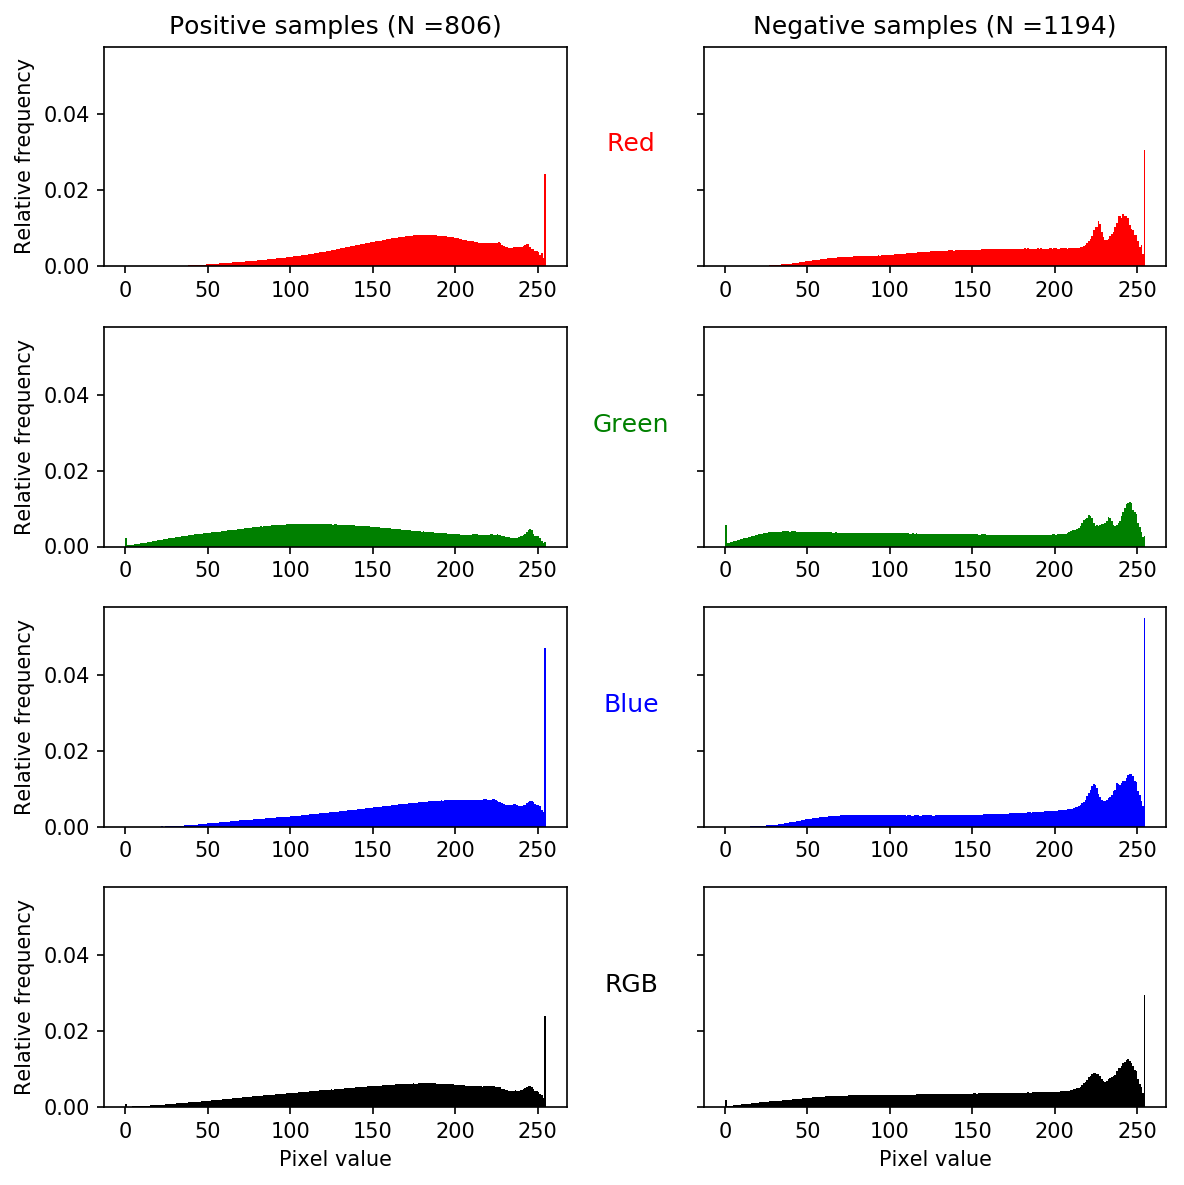

In [16]:
nr_of_bins = 256 #each possible pixel value will get a bin in the following histograms
fig,axs = plt.subplots(4,2,sharey=True,figsize=(8,8),dpi=150)

#RGB channels
axs[0,0].hist(positive_samples[:,:,:,0].flatten(),bins=nr_of_bins,density=True, color="red")
axs[0,1].hist(negative_samples[:,:,:,0].flatten(),bins=nr_of_bins,density=True, color="red")
axs[1,0].hist(positive_samples[:,:,:,1].flatten(),bins=nr_of_bins,density=True, color="green")
axs[1,1].hist(negative_samples[:,:,:,1].flatten(),bins=nr_of_bins,density=True, color="green")
axs[2,0].hist(positive_samples[:,:,:,2].flatten(),bins=nr_of_bins,density=True, color="blue")
axs[2,1].hist(negative_samples[:,:,:,2].flatten(),bins=nr_of_bins,density=True, color="blue")

#All channels
axs[3,0].hist(positive_samples.flatten(),bins=nr_of_bins,density=True, color= 'black')
axs[3,1].hist(negative_samples.flatten(),bins=nr_of_bins,density=True, color= 'black')

#Set image labels
axs[0,0].set_title("Positive samples (N =" + str(positive_samples.shape[0]) + ")");
axs[0,1].set_title("Negative samples (N =" + str(negative_samples.shape[0]) + ")");
axs[0,1].set_ylabel("Red",rotation='horizontal',labelpad=35,fontsize=12, color= 'red')
axs[1,1].set_ylabel("Green",rotation='horizontal',labelpad=35,fontsize=12, color= 'green')
axs[2,1].set_ylabel("Blue",rotation='horizontal',labelpad=35,fontsize=12, color= 'blue')
axs[3,1].set_ylabel("RGB",rotation='horizontal',labelpad=35,fontsize=12)
for i in range(4):
    axs[i,0].set_ylabel("Relative frequency")
axs[3,0].set_xlabel("Pixel value")
axs[3,1].set_xlabel("Pixel value")
fig.tight_layout()


conclusion: obvious differences in the distributions of all channels individually and together between positive and negative samples 
* Negative samples seem to have higher, i.e. brighter, pixel values in general and especially in the green color channel. 
* Interestingly, the positive samples have a darker green channel than red and blue while this is not true for the negative samples. However, very dark pixels are for both sample sets mostly only present in the green channel.
* Furthermore, note the relatively high frequency of the pixel value 255. Looking at the data above we can see, that these can likely be attributed to the bright white image regions present in some images. They seem to be present in both positive and negative samples similarly frequently.

# Train_Test_Split

In [17]:
# attention: random_state = 42 set for constant results and better comparation of different models - remove later
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state = 42)

del X, y

In [18]:
print('x_train shape:', x_train.shape)
print('y_train shape:', y_train.shape)
print(y_train.shape[0], 'train samples')

print('x_test shape:', x_test.shape)
print('y_test shape:', y_test.shape)
print(y_test.shape[0], 'test samples')


x_train shape: (1400, 96, 96, 3)
y_train shape: (1400,)
1400 train samples
x_test shape: (600, 96, 96, 3)
y_test shape: (600,)
600 test samples


# Preprocessing

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

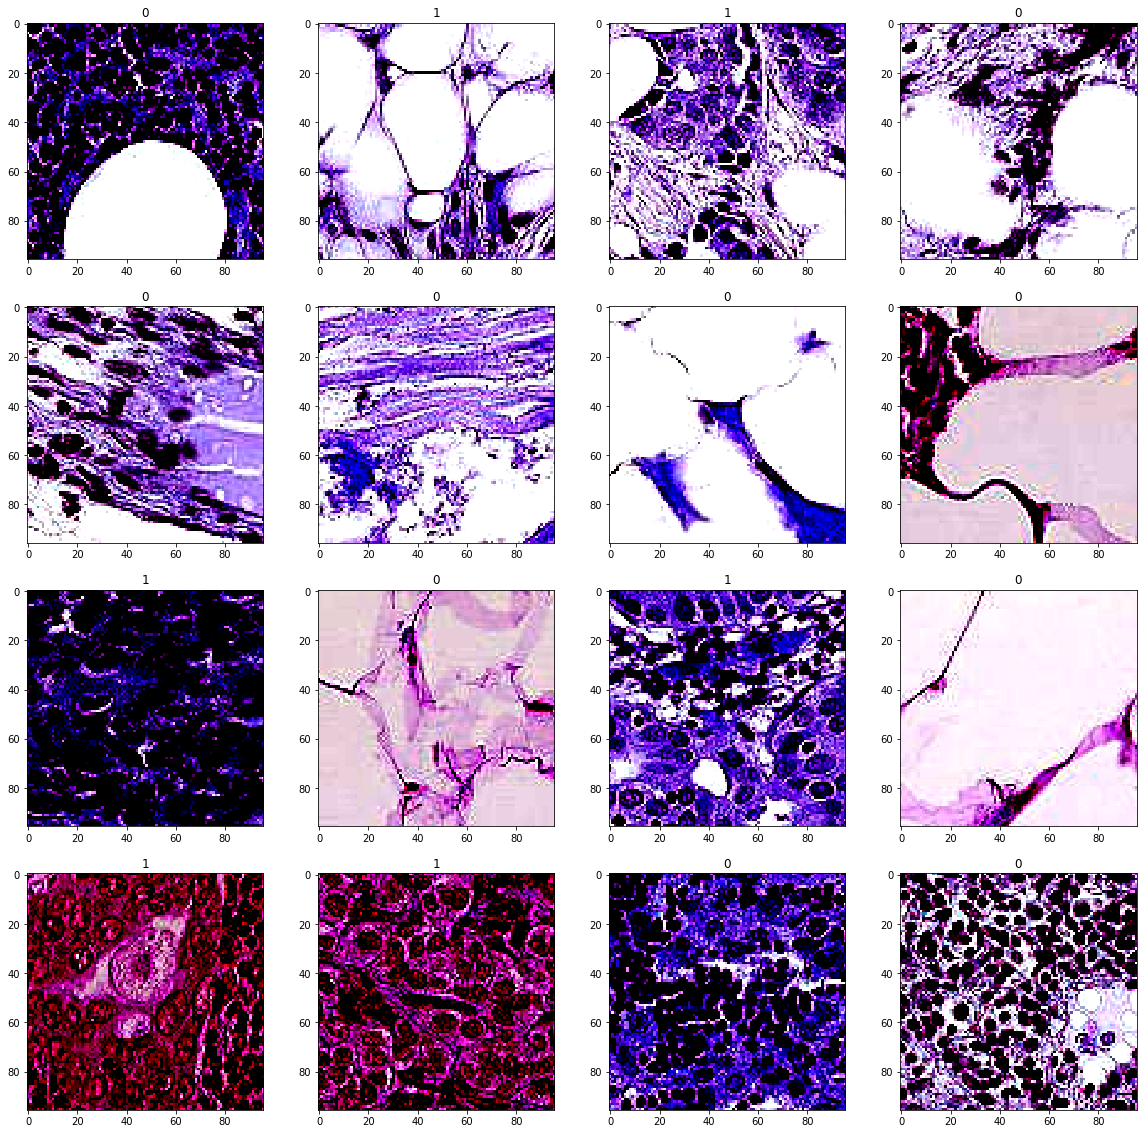

In [19]:
#SCALING (attention delete this part if you use  keras VGG16 or IRNV2 - Preprocessing
#scaling is included  and values will be scaled(/255) again and then be too small
x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255

#Z-SCORE 
mean = np.mean(x_train, axis=(0,1,2,3))
std = np.std(x_train, axis=(0,1,2,3))
x_train = (x_train-mean)/(std+1e-7)
x_test = (x_test-mean)/(std+1e-7)

show_samples(x_train, y_train)


# Image Data Generation

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

350 additional Pictures have been generated! Here are the first 16!


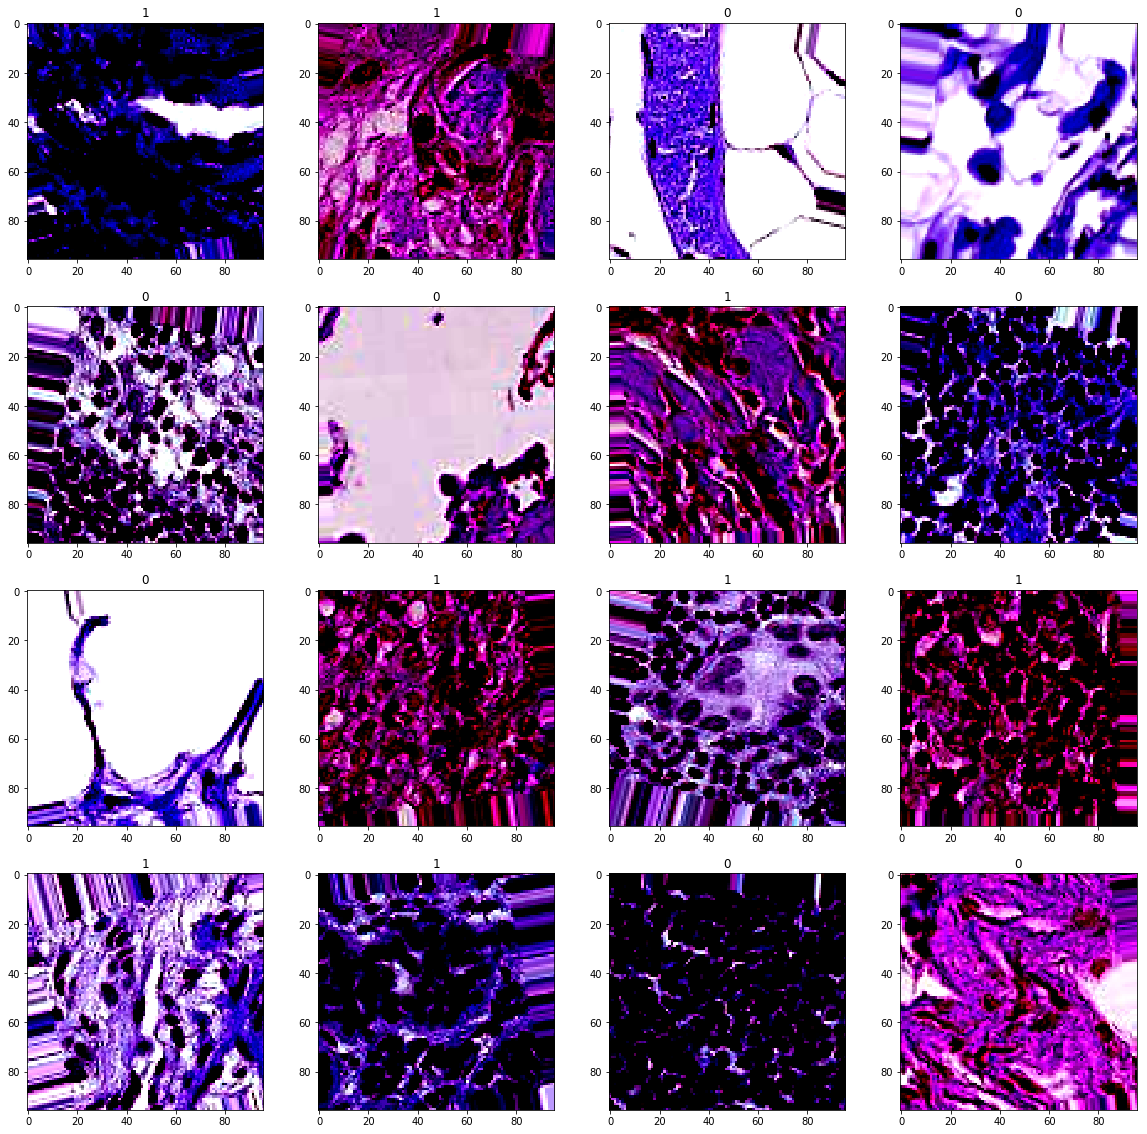

In [20]:
augmenting_proportion = 0.25  # proportion of x_train to augment,  should be max 30%

augment_size = int(x_train.shape[0]*augmenting_proportion) 

datagen = ImageDataGenerator(
    rotation_range=15,
    zoom_range=0.1,
    width_shift_range=0.1,
    shear_range=0.2,
    height_shift_range=0.1,
    horizontal_flip=True,
)

#fit
datagen.fit(x_train, augment=True)

# random id-list/choice of N=augment_size numbers/indexes of pictures of x_train that will be augmented
randidx = np.random.randint(int(x_train.shape[0]), size=augment_size)

#copy o. t. random chosen items of x_train, y_train 
x_augmented = x_train[randidx].copy() 
y_augmented = y_train[randidx].copy() 

x_augmented = datagen.flow(x_augmented, np.zeros(augment_size), batch_size=augment_size, shuffle=False).next()[0]

#show_samples
print(augment_size, "additional Pictures have been generated! Here are the first 16!" )
show_samples(x_augmented, y_augmented)


In [21]:
# append augmented data to trainset
x_train = np.concatenate((x_train, x_augmented))
y_train = np.concatenate((y_train, y_augmented)) 

del x_augmented, y_augmented

# Is the data ready for the NN?

In [22]:
x_train.shape
# the input-shape looks good

(1750, 96, 96, 3)

In [23]:
x_train
# scaling was successfull

array([[[[-1.54136539e+00, -2.37801933e+00, -1.69348443e+00],
         [-1.34361088e+00, -2.14984107e+00, -1.48051786e+00],
         [-1.28276336e+00, -2.05856967e+00, -1.38924658e+00],
         ...,
         [-6.28652215e-01, -1.28276336e+00, -4.15685683e-01],
         [-1.60221303e+00, -2.30195975e+00, -1.51094162e+00],
         [-9.32889938e-01, -1.66306067e+00, -9.32889938e-01]],

        [[-1.08500886e+00, -1.76954389e+00, -1.17628014e+00],
         [-1.23712766e+00, -1.95208645e+00, -1.35882282e+00],
         [-1.28276336e+00, -1.99772215e+00, -1.40445840e+00],
         ...,
         [ 2.53637344e-01, -3.70050013e-01,  4.97027516e-01],
         [ 4.66603756e-01, -1.87507376e-01,  5.88298857e-01],
         [ 3.29696774e-01, -3.54838133e-01,  3.90544325e-01]],

        [[-1.35882282e+00, -1.83039141e+00, -1.38924658e+00],
         [-1.55657744e+00, -2.07378149e+00, -1.61742496e+00],
         [-1.96729839e+00, -2.51492620e+00, -2.07378149e+00],
         ...,
         [ 3.90544325e-0

In [24]:
y_train.shape

(1750,)

In [25]:
# this ist one array of N elements
y_train

array([0, 1, 1, ..., 1, 1, 1])

# Sigmoid() vs. Softmax()
#### sigmoid(): y_train.shape of (N, 1) would be OK if we would use the sigmoid-function later output/prediction would be 0 or 1
#### softmax():  allows us to show probability for 0 or 1 i.e. how "sure" the model/prediction is

##### outputlayers will be:
##### x = Dense(2, name="output")(x)
##### predictions = Activation('softmax')(x)
##### so we need shape (N, 2)

#### conlusion: we need to reshape and to one_hot_encode / to_categorical

In [26]:
# Reshape to N arrays of one element (N, 1)

y_train = y_train.reshape(-1, 1)

y_train.shape

(1750, 1)

In [27]:
y_train
# 0=negative, 1=positive

array([[0],
       [1],
       [1],
       ...,
       [1],
       [1],
       [1]])

# To_Categorical

In [28]:
#TO_CATEGORICAL

# we need shape (8750, 2)

#from keras.utils.np_utils import to_categorical
#from tensorflow.keras.utils import to_categorical

#from keras.utils import to_categorical #läuft

y_train_cat = to_categorical(y_train, 2)

y_test_cat = to_categorical(y_test, 2)

del y_train, y_test

y_train_cat.shape

(1750, 2)

In [29]:
#NEGATIVE =[1, 0] = [position(0/negative)=1=yes,position(1/postive)=0=no] read:sample is negative(yes),positive(no)=NEGATIVE
#POSITIVE =[0, 1] = [position(0/negative)=0=no,position(1/postive)=1=yes] read:sample is negative(no),positive(yes)=POSITIVE

#long story short: position 1/on the right shows the label

y_train_cat

array([[1., 0.],
       [0., 1.],
       [0., 1.],
       ...,
       [0., 1.],
       [0., 1.],
       [0., 1.]], dtype=float32)

In [30]:
# label sample nr. 3(=negative)
y_train_cat[3]

array([1., 0.], dtype=float32)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


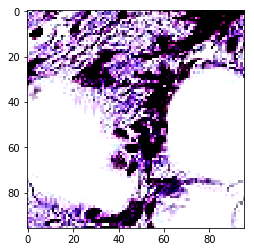

In [31]:
# sample nr. 3
plt.imshow(x_train[3])

In [32]:
#now we have the right shapes
x_train.shape 

(1750, 96, 96, 3)

In [33]:
y_train_cat.shape

(1750, 2)

# Model, Hyperparameter Tuning, Callbacks

#### -try different hyperparameter settings and repeats 
#### -try different base- and top layers (e.g. standardbase vs InceptionResNetV2 (IRNV2) or Flatten() vs "GlobalAveragePooling2D() )
https://keras.io/api/applications/
####  -take "good" parameters for a quick test or uncomment all options below

CURRENT Parameters---------------------------------------------------
repeat: 1
lr: 0.01
optimizer: <keras.optimizers.Adam object at 0x7fbf745b4dd8>
batch_size: 32
base_layer: Standard_base
first_toplayer: Flatten()







Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where



Instructions for updating:
Use standard file APIs to delete files with this prefix.

Epoch 00016: ReduceLROnPlateau reducing learning rate to 0.008999999798834325.

Epoch 00022: ReduceLROnPlateau reducing learning rate to 0.008099999651312828.

Epoch 00028: ReduceLROnPlateau reducing learning rate to 0.007289999350905419.

Epoch 00034: ReduceLROnPlateau reducing learning rate to 0.006560999248176813.
Epoch 00034: early stopping
CURRENT Parameters---------------------------------------------------
repeat: 2
lr: 0.01
optimizer: <keras.optimizers.Adam object at

No handles with labels found to put in legend.


Epoch 00039: early stopping




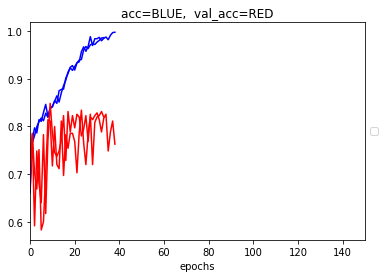

No handles with labels found to put in legend.


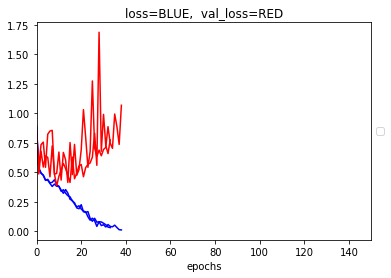

CURRENT Parameters---------------------------------------------------
repeat: 1
lr: 0.01
optimizer: <keras.optimizers.Adam object at 0x7fbf7569e8d0>
batch_size: 64
base_layer: Standard_base
first_toplayer: Flatten()

Epoch 00015: ReduceLROnPlateau reducing learning rate to 0.008999999798834325.

Epoch 00021: ReduceLROnPlateau reducing learning rate to 0.008099999651312828.

Epoch 00027: ReduceLROnPlateau reducing learning rate to 0.007289999350905419.

Epoch 00033: ReduceLROnPlateau reducing learning rate to 0.006560999248176813.
Epoch 00033: early stopping
CURRENT Parameters---------------------------------------------------
repeat: 2
lr: 0.01
optimizer: <keras.optimizers.Adam object at 0x7fbf74bee390>
batch_size: 64
base_layer: Standard_base
first_toplayer: Flatten()

Epoch 00009: ReduceLROnPlateau reducing learning rate to 0.008999999798834325.

Epoch 00024: ReduceLROnPlateau reducing learning rate to 0.008099999651312828.

Epoch 00030: ReduceLROnPlateau reducing learning rate to 0.

No handles with labels found to put in legend.


Epoch 00042: early stopping




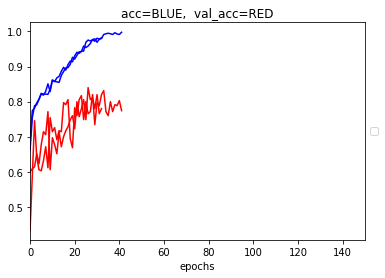

No handles with labels found to put in legend.


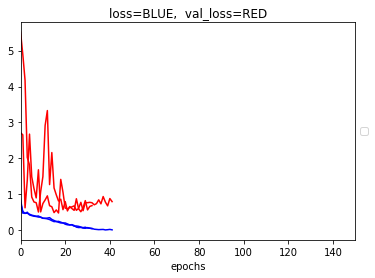

CURRENT Parameters---------------------------------------------------
repeat: 1
lr: 0.01
optimizer: <keras.optimizers.RMSprop object at 0x7fbd14e6cdd8>
batch_size: 32
base_layer: Standard_base
first_toplayer: Flatten()

Epoch 00019: ReduceLROnPlateau reducing learning rate to 0.008999999798834325.

Epoch 00025: ReduceLROnPlateau reducing learning rate to 0.008099999651312828.

Epoch 00031: ReduceLROnPlateau reducing learning rate to 0.007289999350905419.

Epoch 00037: ReduceLROnPlateau reducing learning rate to 0.006560999248176813.
Epoch 00037: early stopping
CURRENT Parameters---------------------------------------------------
repeat: 2
lr: 0.01
optimizer: <keras.optimizers.RMSprop object at 0x7fbd14edf550>
batch_size: 32
base_layer: Standard_base
first_toplayer: Flatten()

Epoch 00016: ReduceLROnPlateau reducing learning rate to 0.008999999798834325.

Epoch 00022: ReduceLROnPlateau reducing learning rate to 0.008099999651312828.

Epoch 00028: ReduceLROnPlateau reducing learning rate

No handles with labels found to put in legend.


Epoch 00034: early stopping




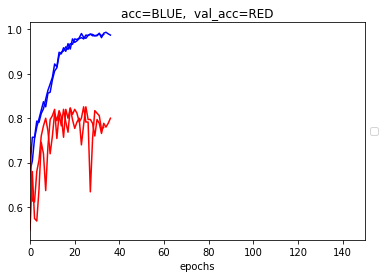

No handles with labels found to put in legend.


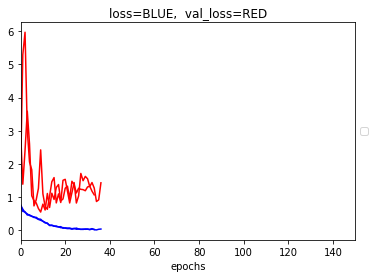

CURRENT Parameters---------------------------------------------------
repeat: 1
lr: 0.01
optimizer: <keras.optimizers.RMSprop object at 0x7fbd1842af60>
batch_size: 64
base_layer: Standard_base
first_toplayer: Flatten()

Epoch 00007: ReduceLROnPlateau reducing learning rate to 0.008999999798834325.

Epoch 00013: ReduceLROnPlateau reducing learning rate to 0.008099999651312828.

Epoch 00019: ReduceLROnPlateau reducing learning rate to 0.007289999350905419.

Epoch 00025: ReduceLROnPlateau reducing learning rate to 0.006560999248176813.
Epoch 00025: early stopping
CURRENT Parameters---------------------------------------------------
repeat: 2
lr: 0.01
optimizer: <keras.optimizers.RMSprop object at 0x7fbd1a074a58>
batch_size: 64
base_layer: Standard_base
first_toplayer: Flatten()

Epoch 00007: ReduceLROnPlateau reducing learning rate to 0.008999999798834325.

Epoch 00016: ReduceLROnPlateau reducing learning rate to 0.008099999651312828.

Epoch 00022: ReduceLROnPlateau reducing learning rate

No handles with labels found to put in legend.


Epoch 00034: early stopping




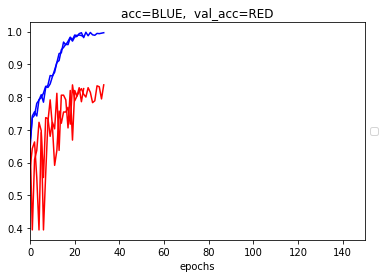

No handles with labels found to put in legend.


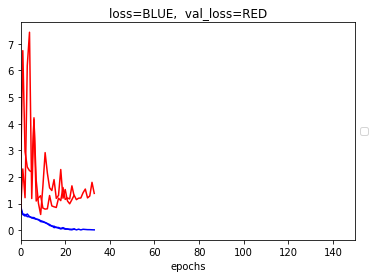

CURRENT Parameters---------------------------------------------------
repeat: 1
lr: 0.001
optimizer: <keras.optimizers.Adam object at 0x7fbf74c00d68>
batch_size: 32
base_layer: Standard_base
first_toplayer: Flatten()

Epoch 00011: ReduceLROnPlateau reducing learning rate to 0.0009000000427477062.

Epoch 00017: ReduceLROnPlateau reducing learning rate to 0.0008100000384729356.

Epoch 00023: ReduceLROnPlateau reducing learning rate to 0.0007290000503417104.

Epoch 00029: ReduceLROnPlateau reducing learning rate to 0.0006561000715009868.
Epoch 00029: early stopping
CURRENT Parameters---------------------------------------------------
repeat: 2
lr: 0.001
optimizer: <keras.optimizers.Adam object at 0x7fbd15281828>
batch_size: 32
base_layer: Standard_base
first_toplayer: Flatten()

Epoch 00016: ReduceLROnPlateau reducing learning rate to 0.0009000000427477062.

Epoch 00022: ReduceLROnPlateau reducing learning rate to 0.0008100000384729356.

Epoch 00028: ReduceLROnPlateau reducing learning ra

No handles with labels found to put in legend.


Epoch 00034: early stopping




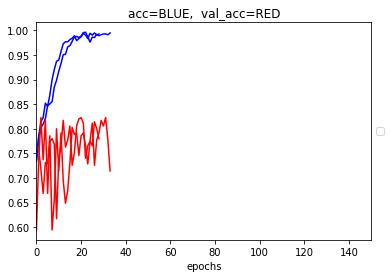

No handles with labels found to put in legend.


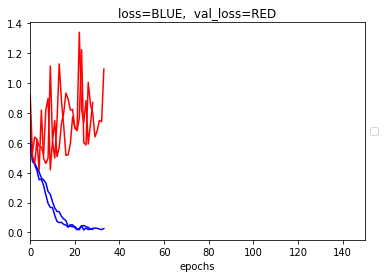

CURRENT Parameters---------------------------------------------------
repeat: 1
lr: 0.001
optimizer: <keras.optimizers.Adam object at 0x7fbd19ca6320>
batch_size: 64
base_layer: Standard_base
first_toplayer: Flatten()

Epoch 00008: ReduceLROnPlateau reducing learning rate to 0.0009000000427477062.

Epoch 00020: ReduceLROnPlateau reducing learning rate to 0.0008100000384729356.

Epoch 00026: ReduceLROnPlateau reducing learning rate to 0.0007290000503417104.

Epoch 00032: ReduceLROnPlateau reducing learning rate to 0.0006561000715009868.

Epoch 00038: ReduceLROnPlateau reducing learning rate to 0.0005904900433961303.
Epoch 00038: early stopping
CURRENT Parameters---------------------------------------------------
repeat: 2
lr: 0.001
optimizer: <keras.optimizers.Adam object at 0x7fbd18834978>
batch_size: 64
base_layer: Standard_base
first_toplayer: Flatten()

Epoch 00014: ReduceLROnPlateau reducing learning rate to 0.0009000000427477062.

Epoch 00021: ReduceLROnPlateau reducing learning ra

No handles with labels found to put in legend.


Epoch 00039: early stopping




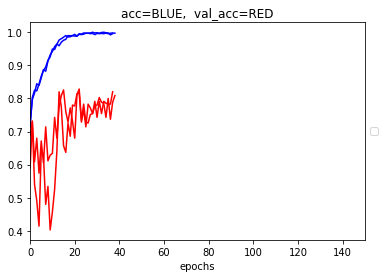

No handles with labels found to put in legend.


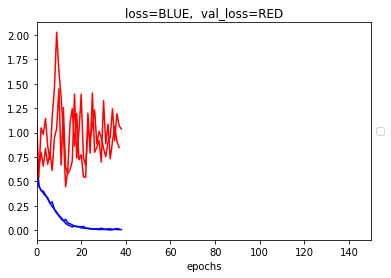

CURRENT Parameters---------------------------------------------------
repeat: 1
lr: 0.001
optimizer: <keras.optimizers.RMSprop object at 0x7fbd19c8f240>
batch_size: 32
base_layer: Standard_base
first_toplayer: Flatten()

Epoch 00015: ReduceLROnPlateau reducing learning rate to 0.0009000000427477062.

Epoch 00021: ReduceLROnPlateau reducing learning rate to 0.0008100000384729356.

Epoch 00027: ReduceLROnPlateau reducing learning rate to 0.0007290000503417104.

Epoch 00033: ReduceLROnPlateau reducing learning rate to 0.0006561000715009868.
Epoch 00033: early stopping
CURRENT Parameters---------------------------------------------------
repeat: 2
lr: 0.001
optimizer: <keras.optimizers.RMSprop object at 0x7fbd1928ba58>
batch_size: 32
base_layer: Standard_base
first_toplayer: Flatten()

Epoch 00014: ReduceLROnPlateau reducing learning rate to 0.0009000000427477062.

Epoch 00020: ReduceLROnPlateau reducing learning rate to 0.0008100000384729356.

Epoch 00026: ReduceLROnPlateau reducing learn

No handles with labels found to put in legend.


Epoch 00032: early stopping




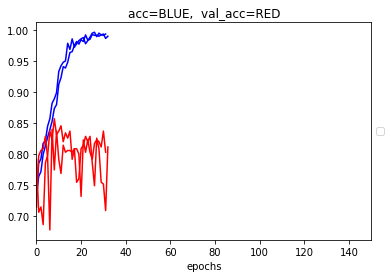

No handles with labels found to put in legend.


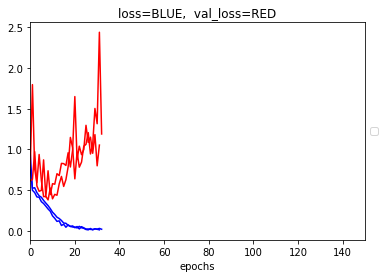

CURRENT Parameters---------------------------------------------------
repeat: 1
lr: 0.001
optimizer: <keras.optimizers.RMSprop object at 0x7fbf73a590b8>
batch_size: 64
base_layer: Standard_base
first_toplayer: Flatten()

Epoch 00016: ReduceLROnPlateau reducing learning rate to 0.0009000000427477062.

Epoch 00022: ReduceLROnPlateau reducing learning rate to 0.0008100000384729356.

Epoch 00028: ReduceLROnPlateau reducing learning rate to 0.0007290000503417104.

Epoch 00034: ReduceLROnPlateau reducing learning rate to 0.0006561000715009868.
Epoch 00034: early stopping
CURRENT Parameters---------------------------------------------------
repeat: 2
lr: 0.001
optimizer: <keras.optimizers.RMSprop object at 0x7fbf73b71d68>
batch_size: 64
base_layer: Standard_base
first_toplayer: Flatten()

Epoch 00013: ReduceLROnPlateau reducing learning rate to 0.0009000000427477062.

Epoch 00019: ReduceLROnPlateau reducing learning rate to 0.0008100000384729356.

Epoch 00025: ReduceLROnPlateau reducing learn

No handles with labels found to put in legend.


Epoch 00031: early stopping




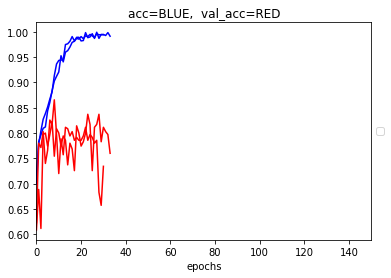

No handles with labels found to put in legend.


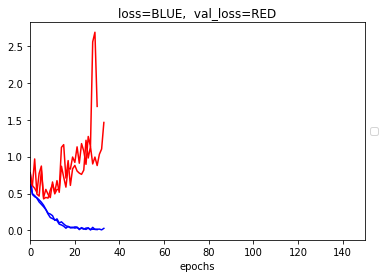

CURRENT Parameters---------------------------------------------------
repeat: 1
lr: 0.01
optimizer: <keras.optimizers.Adam object at 0x7fbd154d2cc0>
batch_size: 32
base_layer: InceptionResNetV2_base
first_toplayer: Flatten()


Epoch 00014: ReduceLROnPlateau reducing learning rate to 0.008999999798834325.

Epoch 00020: ReduceLROnPlateau reducing learning rate to 0.008099999651312828.

Epoch 00035: ReduceLROnPlateau reducing learning rate to 0.007289999350905419.

Epoch 00041: ReduceLROnPlateau reducing learning rate to 0.006560999248176813.

Epoch 00047: ReduceLROnPlateau reducing learning rate to 0.005904899490997195.

Epoch 00053: ReduceLROnPlateau reducing learning rate to 0.00531440949998796.
Epoch 00053: early stopping
CURRENT Parameters---------------------------------------------------
repeat: 2
lr: 0.01
optimizer: <keras.optimizers.Adam object at 0x7fbc8ce69550>
batch_size: 32
base_layer: InceptionResNetV2_base
first_toplayer: Flatten()

Epoch 00010: ReduceLROnPlateau reducing l

No handles with labels found to put in legend.


Epoch 00121: early stopping




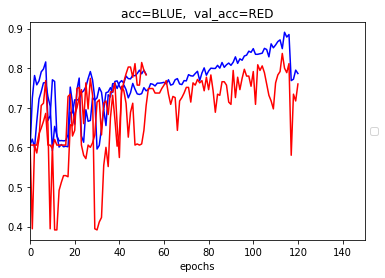

No handles with labels found to put in legend.


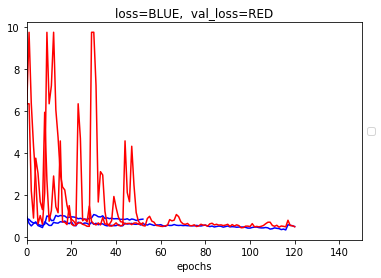

CURRENT Parameters---------------------------------------------------
repeat: 1
lr: 0.01
optimizer: <keras.optimizers.Adam object at 0x7fbc5cbe4ac8>
batch_size: 64
base_layer: InceptionResNetV2_base
first_toplayer: Flatten()

Epoch 00014: ReduceLROnPlateau reducing learning rate to 0.008999999798834325.

Epoch 00020: ReduceLROnPlateau reducing learning rate to 0.008099999651312828.

Epoch 00028: ReduceLROnPlateau reducing learning rate to 0.007289999350905419.

Epoch 00052: ReduceLROnPlateau reducing learning rate to 0.006560999248176813.

Epoch 00058: ReduceLROnPlateau reducing learning rate to 0.005904899490997195.

Epoch 00064: ReduceLROnPlateau reducing learning rate to 0.00531440949998796.

Epoch 00070: ReduceLROnPlateau reducing learning rate to 0.004782968759536744.
Epoch 00070: early stopping
CURRENT Parameters---------------------------------------------------
repeat: 2
lr: 0.01
optimizer: <keras.optimizers.Adam object at 0x7fbca86ee898>
batch_size: 64
base_layer: InceptionRes

No handles with labels found to put in legend.


Epoch 00074: early stopping




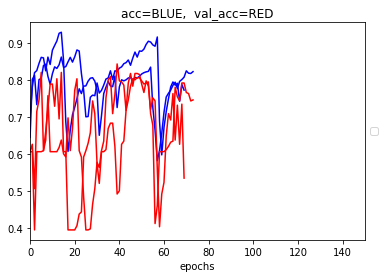

No handles with labels found to put in legend.


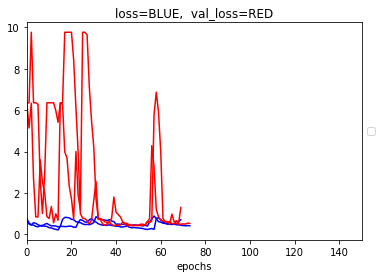

CURRENT Parameters---------------------------------------------------
repeat: 1
lr: 0.01
optimizer: <keras.optimizers.RMSprop object at 0x7fbc6bd10b70>
batch_size: 32
base_layer: InceptionResNetV2_base
first_toplayer: Flatten()

Epoch 00013: ReduceLROnPlateau reducing learning rate to 0.008999999798834325.

Epoch 00024: ReduceLROnPlateau reducing learning rate to 0.008099999651312828.

Epoch 00033: ReduceLROnPlateau reducing learning rate to 0.007289999350905419.

Epoch 00039: ReduceLROnPlateau reducing learning rate to 0.006560999248176813.

Epoch 00046: ReduceLROnPlateau reducing learning rate to 0.005904899490997195.

Epoch 00052: ReduceLROnPlateau reducing learning rate to 0.00531440949998796.

Epoch 00058: ReduceLROnPlateau reducing learning rate to 0.004782968759536744.

Epoch 00064: ReduceLROnPlateau reducing learning rate to 0.0043046717997640375.
Epoch 00064: early stopping
CURRENT Parameters---------------------------------------------------
repeat: 2
lr: 0.01
optimizer: <ker

No handles with labels found to put in legend.


Epoch 00050: early stopping




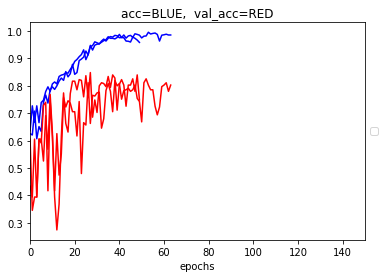

No handles with labels found to put in legend.


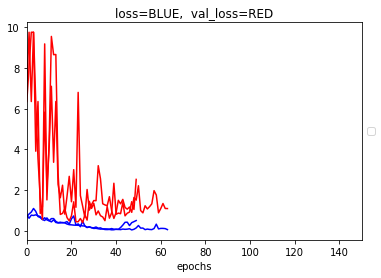

CURRENT Parameters---------------------------------------------------
repeat: 1
lr: 0.01
optimizer: <keras.optimizers.RMSprop object at 0x7fbc6bd5ceb8>
batch_size: 64
base_layer: InceptionResNetV2_base
first_toplayer: Flatten()

Epoch 00011: ReduceLROnPlateau reducing learning rate to 0.008999999798834325.

Epoch 00035: ReduceLROnPlateau reducing learning rate to 0.008099999651312828.

Epoch 00044: ReduceLROnPlateau reducing learning rate to 0.007289999350905419.

Epoch 00050: ReduceLROnPlateau reducing learning rate to 0.006560999248176813.

Epoch 00056: ReduceLROnPlateau reducing learning rate to 0.005904899490997195.

Epoch 00062: ReduceLROnPlateau reducing learning rate to 0.00531440949998796.
Epoch 00062: early stopping
CURRENT Parameters---------------------------------------------------
repeat: 2
lr: 0.01
optimizer: <keras.optimizers.RMSprop object at 0x7fbc73be71d0>
batch_size: 64
base_layer: InceptionResNetV2_base
first_toplayer: Flatten()

Epoch 00007: ReduceLROnPlateau reduc

No handles with labels found to put in legend.


Epoch 00025: early stopping




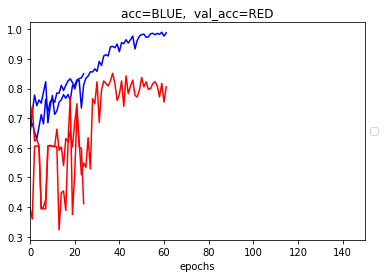

No handles with labels found to put in legend.


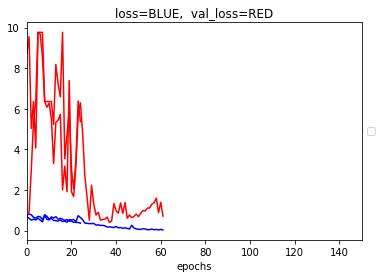

CURRENT Parameters---------------------------------------------------
repeat: 1
lr: 0.001
optimizer: <keras.optimizers.Adam object at 0x7fbc6d15d9b0>
batch_size: 32
base_layer: InceptionResNetV2_base
first_toplayer: Flatten()

Epoch 00008: ReduceLROnPlateau reducing learning rate to 0.0009000000427477062.

Epoch 00020: ReduceLROnPlateau reducing learning rate to 0.0008100000384729356.

Epoch 00026: ReduceLROnPlateau reducing learning rate to 0.0007290000503417104.

Epoch 00032: ReduceLROnPlateau reducing learning rate to 0.0006561000715009868.

Epoch 00038: ReduceLROnPlateau reducing learning rate to 0.0005904900433961303.
Epoch 00038: early stopping
CURRENT Parameters---------------------------------------------------
repeat: 2
lr: 0.001
optimizer: <keras.optimizers.Adam object at 0x7fbc90131b70>
batch_size: 32
base_layer: InceptionResNetV2_base
first_toplayer: Flatten()

Epoch 00021: ReduceLROnPlateau reducing learning rate to 0.0009000000427477062.

Epoch 00027: ReduceLROnPlateau re

No handles with labels found to put in legend.


Epoch 00059: early stopping




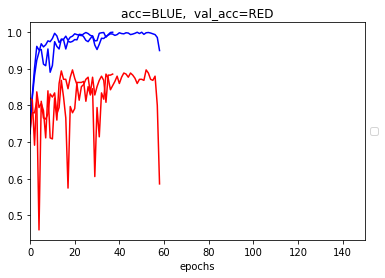

No handles with labels found to put in legend.


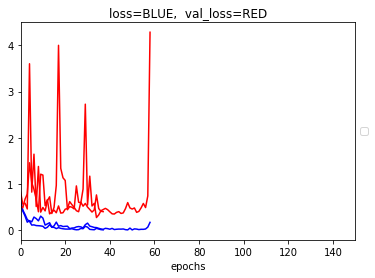

CURRENT Parameters---------------------------------------------------
repeat: 1
lr: 0.001
optimizer: <keras.optimizers.Adam object at 0x7fbc6d18ffd0>
batch_size: 64
base_layer: InceptionResNetV2_base
first_toplayer: Flatten()

Epoch 00017: ReduceLROnPlateau reducing learning rate to 0.0009000000427477062.

Epoch 00023: ReduceLROnPlateau reducing learning rate to 0.0008100000384729356.

Epoch 00029: ReduceLROnPlateau reducing learning rate to 0.0007290000503417104.

Epoch 00035: ReduceLROnPlateau reducing learning rate to 0.0006561000715009868.
Epoch 00035: early stopping
CURRENT Parameters---------------------------------------------------
repeat: 2
lr: 0.001
optimizer: <keras.optimizers.Adam object at 0x7fbc699756d8>
batch_size: 64
base_layer: InceptionResNetV2_base
first_toplayer: Flatten()

Epoch 00010: ReduceLROnPlateau reducing learning rate to 0.0009000000427477062.

Epoch 00017: ReduceLROnPlateau reducing learning rate to 0.0008100000384729356.

Epoch 00031: ReduceLROnPlateau re

No handles with labels found to put in legend.


Epoch 00049: early stopping




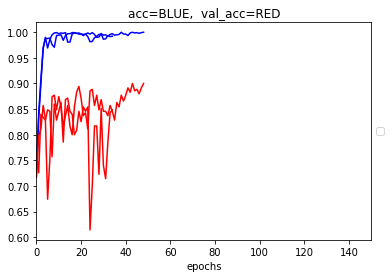

No handles with labels found to put in legend.


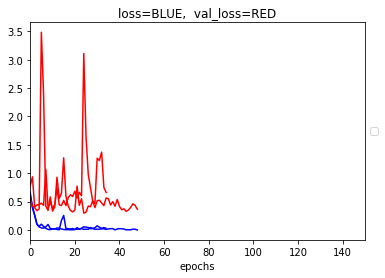

CURRENT Parameters---------------------------------------------------
repeat: 1
lr: 0.001
optimizer: <keras.optimizers.RMSprop object at 0x7fbc771a0d30>
batch_size: 32
base_layer: InceptionResNetV2_base
first_toplayer: Flatten()

Epoch 00008: ReduceLROnPlateau reducing learning rate to 0.0009000000427477062.

Epoch 00023: ReduceLROnPlateau reducing learning rate to 0.0008100000384729356.

Epoch 00029: ReduceLROnPlateau reducing learning rate to 0.0007290000503417104.

Epoch 00035: ReduceLROnPlateau reducing learning rate to 0.0006561000715009868.

Epoch 00041: ReduceLROnPlateau reducing learning rate to 0.0005904900433961303.
Epoch 00041: early stopping
CURRENT Parameters---------------------------------------------------
repeat: 2
lr: 0.001
optimizer: <keras.optimizers.RMSprop object at 0x7fbc9794b080>
batch_size: 32
base_layer: InceptionResNetV2_base
first_toplayer: Flatten()

Epoch 00007: ReduceLROnPlateau reducing learning rate to 0.0009000000427477062.

Epoch 00013: ReduceLROnPlat

No handles with labels found to put in legend.


Epoch 00025: early stopping




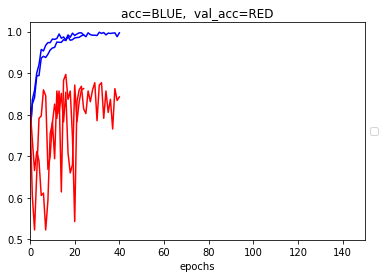

No handles with labels found to put in legend.


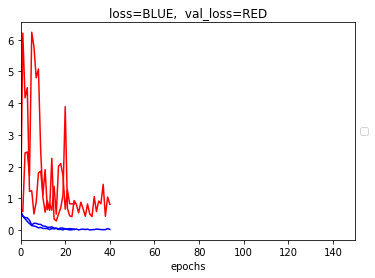

CURRENT Parameters---------------------------------------------------
repeat: 1
lr: 0.001
optimizer: <keras.optimizers.RMSprop object at 0x7fbc771bf940>
batch_size: 64
base_layer: InceptionResNetV2_base
first_toplayer: Flatten()

Epoch 00011: ReduceLROnPlateau reducing learning rate to 0.0009000000427477062.

Epoch 00017: ReduceLROnPlateau reducing learning rate to 0.0008100000384729356.

Epoch 00023: ReduceLROnPlateau reducing learning rate to 0.0007290000503417104.

Epoch 00029: ReduceLROnPlateau reducing learning rate to 0.0006561000715009868.
Epoch 00029: early stopping
CURRENT Parameters---------------------------------------------------
repeat: 2
lr: 0.001
optimizer: <keras.optimizers.RMSprop object at 0x7fbc736092e8>
batch_size: 64
base_layer: InceptionResNetV2_base
first_toplayer: Flatten()

Epoch 00010: ReduceLROnPlateau reducing learning rate to 0.0009000000427477062.

Epoch 00016: ReduceLROnPlateau reducing learning rate to 0.0008100000384729356.

Epoch 00022: ReduceLROnPlat

No handles with labels found to put in legend.


Epoch 00028: early stopping




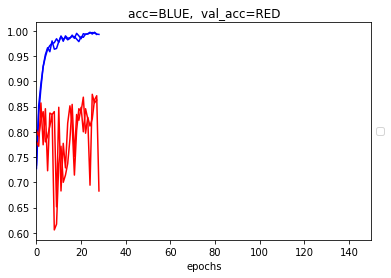

No handles with labels found to put in legend.


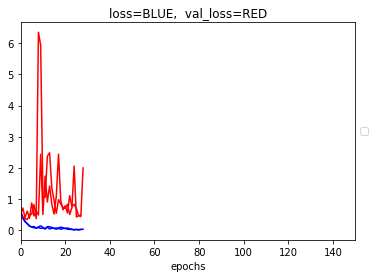

CURRENT Parameters---------------------------------------------------
repeat: 1
lr: 0.01
optimizer: <keras.optimizers.Adam object at 0x7fbc6e80e160>
batch_size: 32
base_layer: Standard_base
first_toplayer: GlobalAveragePooling2D()

Epoch 00025: ReduceLROnPlateau reducing learning rate to 0.008999999798834325.

Epoch 00031: ReduceLROnPlateau reducing learning rate to 0.008099999651312828.

Epoch 00037: ReduceLROnPlateau reducing learning rate to 0.007289999350905419.

Epoch 00051: ReduceLROnPlateau reducing learning rate to 0.006560999248176813.

Epoch 00059: ReduceLROnPlateau reducing learning rate to 0.005904899490997195.

Epoch 00065: ReduceLROnPlateau reducing learning rate to 0.00531440949998796.

Epoch 00071: ReduceLROnPlateau reducing learning rate to 0.004782968759536744.

Epoch 00077: ReduceLROnPlateau reducing learning rate to 0.0043046717997640375.
Epoch 00077: early stopping
CURRENT Parameters---------------------------------------------------
repeat: 2
lr: 0.01
optimizer: <

No handles with labels found to put in legend.


Epoch 00092: early stopping




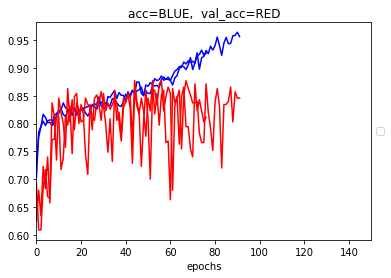

No handles with labels found to put in legend.


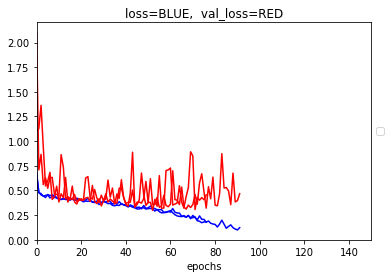

CURRENT Parameters---------------------------------------------------
repeat: 1
lr: 0.01
optimizer: <keras.optimizers.Adam object at 0x7fbc970622e8>
batch_size: 64
base_layer: Standard_base
first_toplayer: GlobalAveragePooling2D()

Epoch 00009: ReduceLROnPlateau reducing learning rate to 0.008999999798834325.

Epoch 00015: ReduceLROnPlateau reducing learning rate to 0.008099999651312828.

Epoch 00042: ReduceLROnPlateau reducing learning rate to 0.007289999350905419.

Epoch 00052: ReduceLROnPlateau reducing learning rate to 0.006560999248176813.

Epoch 00062: ReduceLROnPlateau reducing learning rate to 0.005904899490997195.

Epoch 00071: ReduceLROnPlateau reducing learning rate to 0.00531440949998796.

Epoch 00077: ReduceLROnPlateau reducing learning rate to 0.004782968759536744.

Epoch 00083: ReduceLROnPlateau reducing learning rate to 0.0043046717997640375.

Epoch 00095: ReduceLROnPlateau reducing learning rate to 0.0038742044940590858.

Epoch 00101: ReduceLROnPlateau reducing learnin

No handles with labels found to put in legend.


Epoch 00097: early stopping




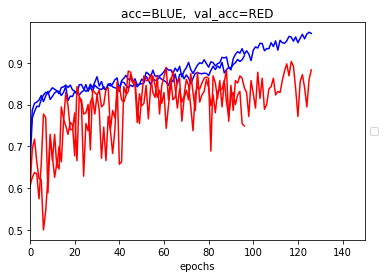

No handles with labels found to put in legend.


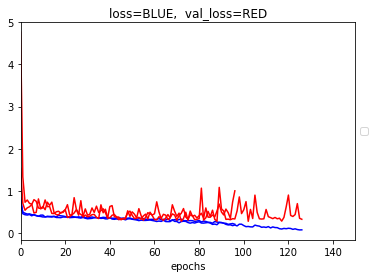

CURRENT Parameters---------------------------------------------------
repeat: 1
lr: 0.01
optimizer: <keras.optimizers.RMSprop object at 0x7fbc5dc56d30>
batch_size: 32
base_layer: Standard_base
first_toplayer: GlobalAveragePooling2D()

Epoch 00015: ReduceLROnPlateau reducing learning rate to 0.008999999798834325.

Epoch 00021: ReduceLROnPlateau reducing learning rate to 0.008099999651312828.

Epoch 00035: ReduceLROnPlateau reducing learning rate to 0.007289999350905419.

Epoch 00042: ReduceLROnPlateau reducing learning rate to 0.006560999248176813.

Epoch 00060: ReduceLROnPlateau reducing learning rate to 0.005904899490997195.

Epoch 00066: ReduceLROnPlateau reducing learning rate to 0.00531440949998796.

Epoch 00072: ReduceLROnPlateau reducing learning rate to 0.004782968759536744.

Epoch 00078: ReduceLROnPlateau reducing learning rate to 0.0043046717997640375.
Epoch 00078: early stopping
CURRENT Parameters---------------------------------------------------
repeat: 2
lr: 0.01
optimizer

No handles with labels found to put in legend.


Epoch 00084: early stopping




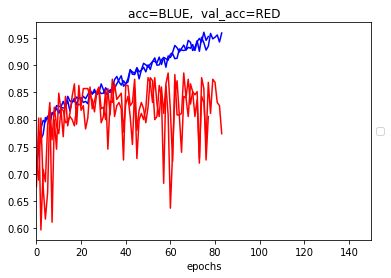

No handles with labels found to put in legend.


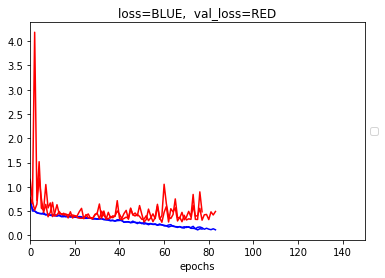

CURRENT Parameters---------------------------------------------------
repeat: 1
lr: 0.01
optimizer: <keras.optimizers.RMSprop object at 0x7fbc95acba58>
batch_size: 64
base_layer: Standard_base
first_toplayer: GlobalAveragePooling2D()

Epoch 00008: ReduceLROnPlateau reducing learning rate to 0.008999999798834325.

Epoch 00023: ReduceLROnPlateau reducing learning rate to 0.008099999651312828.

Epoch 00031: ReduceLROnPlateau reducing learning rate to 0.007289999350905419.

Epoch 00046: ReduceLROnPlateau reducing learning rate to 0.006560999248176813.

Epoch 00052: ReduceLROnPlateau reducing learning rate to 0.005904899490997195.

Epoch 00062: ReduceLROnPlateau reducing learning rate to 0.00531440949998796.

Epoch 00068: ReduceLROnPlateau reducing learning rate to 0.004782968759536744.

Epoch 00074: ReduceLROnPlateau reducing learning rate to 0.0043046717997640375.

Epoch 00080: ReduceLROnPlateau reducing learning rate to 0.0038742044940590858.
Epoch 00080: early stopping
CURRENT Parameter

No handles with labels found to put in legend.


Epoch 00076: early stopping




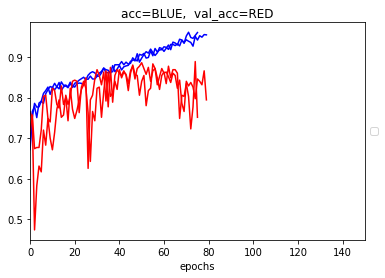

No handles with labels found to put in legend.


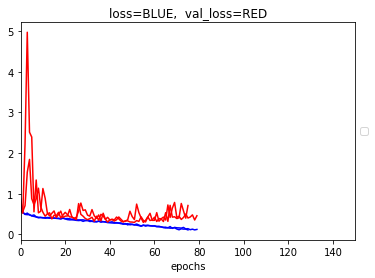

CURRENT Parameters---------------------------------------------------
repeat: 1
lr: 0.001
optimizer: <keras.optimizers.Adam object at 0x7fbcaa234a20>
batch_size: 32
base_layer: Standard_base
first_toplayer: GlobalAveragePooling2D()

Epoch 00012: ReduceLROnPlateau reducing learning rate to 0.0009000000427477062.

Epoch 00020: ReduceLROnPlateau reducing learning rate to 0.0008100000384729356.

Epoch 00033: ReduceLROnPlateau reducing learning rate to 0.0007290000503417104.

Epoch 00039: ReduceLROnPlateau reducing learning rate to 0.0006561000715009868.

Epoch 00054: ReduceLROnPlateau reducing learning rate to 0.0005904900433961303.

Epoch 00060: ReduceLROnPlateau reducing learning rate to 0.0005314410547725857.

Epoch 00066: ReduceLROnPlateau reducing learning rate to 0.00047829695977270604.

Epoch 00072: ReduceLROnPlateau reducing learning rate to 0.0004304672533180565.
Epoch 00072: early stopping
CURRENT Parameters---------------------------------------------------
repeat: 2
lr: 0.001
o

No handles with labels found to put in legend.


Epoch 00048: early stopping




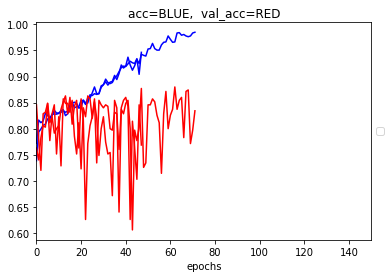

No handles with labels found to put in legend.


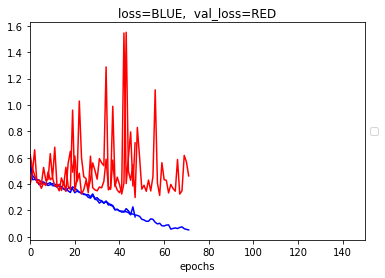

CURRENT Parameters---------------------------------------------------
repeat: 1
lr: 0.001
optimizer: <keras.optimizers.Adam object at 0x7fbc8e89f588>
batch_size: 64
base_layer: Standard_base
first_toplayer: GlobalAveragePooling2D()

Epoch 00008: ReduceLROnPlateau reducing learning rate to 0.0009000000427477062.

Epoch 00025: ReduceLROnPlateau reducing learning rate to 0.0008100000384729356.

Epoch 00031: ReduceLROnPlateau reducing learning rate to 0.0007290000503417104.

Epoch 00037: ReduceLROnPlateau reducing learning rate to 0.0006561000715009868.

Epoch 00043: ReduceLROnPlateau reducing learning rate to 0.0005904900433961303.
Epoch 00043: early stopping
CURRENT Parameters---------------------------------------------------
repeat: 2
lr: 0.001
optimizer: <keras.optimizers.Adam object at 0x7fbc6bc75d30>
batch_size: 64
base_layer: Standard_base
first_toplayer: GlobalAveragePooling2D()

Epoch 00041: ReduceLROnPlateau reducing learning rate to 0.0009000000427477062.

Epoch 00047: ReduceLR

No handles with labels found to put in legend.


Epoch 00085: early stopping




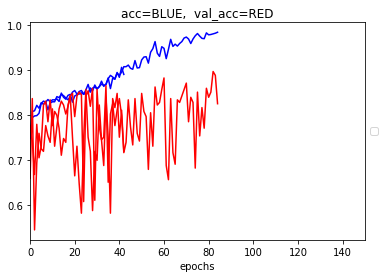

No handles with labels found to put in legend.


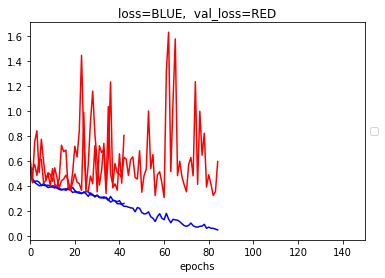

CURRENT Parameters---------------------------------------------------
repeat: 1
lr: 0.001
optimizer: <keras.optimizers.RMSprop object at 0x7fbca8780240>
batch_size: 32
base_layer: Standard_base
first_toplayer: GlobalAveragePooling2D()

Epoch 00018: ReduceLROnPlateau reducing learning rate to 0.0009000000427477062.

Epoch 00024: ReduceLROnPlateau reducing learning rate to 0.0008100000384729356.

Epoch 00038: ReduceLROnPlateau reducing learning rate to 0.0007290000503417104.

Epoch 00044: ReduceLROnPlateau reducing learning rate to 0.0006561000715009868.

Epoch 00050: ReduceLROnPlateau reducing learning rate to 0.0005904900433961303.

Epoch 00056: ReduceLROnPlateau reducing learning rate to 0.0005314410547725857.
Epoch 00056: early stopping
CURRENT Parameters---------------------------------------------------
repeat: 2
lr: 0.001
optimizer: <keras.optimizers.RMSprop object at 0x7fbc752f0438>
batch_size: 32
base_layer: Standard_base
first_toplayer: GlobalAveragePooling2D()

Epoch 00008: Re

No handles with labels found to put in legend.


Epoch 00049: early stopping




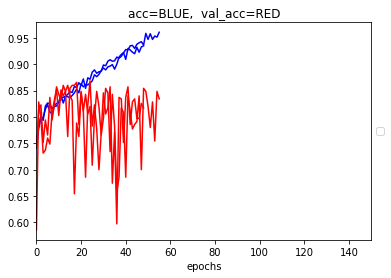

No handles with labels found to put in legend.


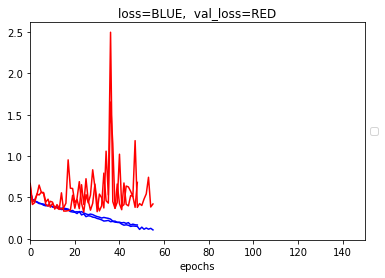

CURRENT Parameters---------------------------------------------------
repeat: 1
lr: 0.001
optimizer: <keras.optimizers.RMSprop object at 0x7fbc699fbf28>
batch_size: 64
base_layer: Standard_base
first_toplayer: GlobalAveragePooling2D()

Epoch 00010: ReduceLROnPlateau reducing learning rate to 0.0009000000427477062.

Epoch 00020: ReduceLROnPlateau reducing learning rate to 0.0008100000384729356.

Epoch 00026: ReduceLROnPlateau reducing learning rate to 0.0007290000503417104.

Epoch 00032: ReduceLROnPlateau reducing learning rate to 0.0006561000715009868.

Epoch 00038: ReduceLROnPlateau reducing learning rate to 0.0005904900433961303.
Epoch 00038: early stopping
CURRENT Parameters---------------------------------------------------
repeat: 2
lr: 0.001
optimizer: <keras.optimizers.RMSprop object at 0x7fbc6356c550>
batch_size: 64
base_layer: Standard_base
first_toplayer: GlobalAveragePooling2D()

Epoch 00011: ReduceLROnPlateau reducing learning rate to 0.0009000000427477062.

Epoch 00023: Re

No handles with labels found to put in legend.



Epoch 00041: ReduceLROnPlateau reducing learning rate to 0.0005904900433961303.
Epoch 00041: early stopping




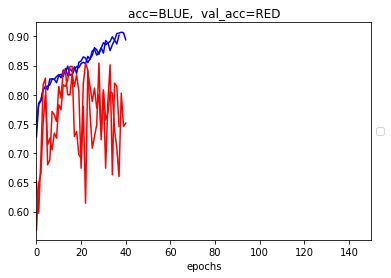

No handles with labels found to put in legend.


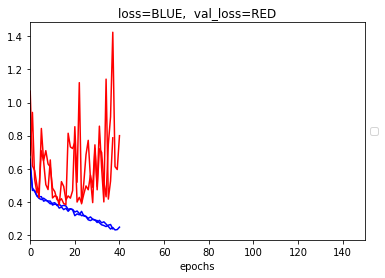

CURRENT Parameters---------------------------------------------------
repeat: 1
lr: 0.01
optimizer: <keras.optimizers.Adam object at 0x7fbcaa76fef0>
batch_size: 32
base_layer: InceptionResNetV2_base
first_toplayer: GlobalAveragePooling2D()

Epoch 00009: ReduceLROnPlateau reducing learning rate to 0.008999999798834325.

Epoch 00015: ReduceLROnPlateau reducing learning rate to 0.008099999651312828.

Epoch 00029: ReduceLROnPlateau reducing learning rate to 0.007289999350905419.

Epoch 00043: ReduceLROnPlateau reducing learning rate to 0.006560999248176813.

Epoch 00049: ReduceLROnPlateau reducing learning rate to 0.005904899490997195.

Epoch 00055: ReduceLROnPlateau reducing learning rate to 0.00531440949998796.

Epoch 00061: ReduceLROnPlateau reducing learning rate to 0.004782968759536744.
Epoch 00061: early stopping
CURRENT Parameters---------------------------------------------------
repeat: 2
lr: 0.01
optimizer: <keras.optimizers.Adam object at 0x7fbcc3e3aef0>
batch_size: 32
base_laye

No handles with labels found to put in legend.


Epoch 00072: early stopping




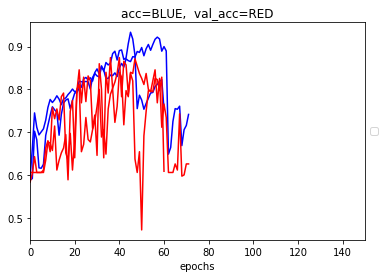

No handles with labels found to put in legend.


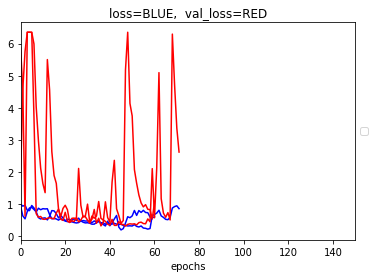

CURRENT Parameters---------------------------------------------------
repeat: 1
lr: 0.01
optimizer: <keras.optimizers.Adam object at 0x7fbd0ebc8c18>
batch_size: 64
base_layer: InceptionResNetV2_base
first_toplayer: GlobalAveragePooling2D()

Epoch 00008: ReduceLROnPlateau reducing learning rate to 0.008999999798834325.

Epoch 00054: ReduceLROnPlateau reducing learning rate to 0.008099999651312828.

Epoch 00060: ReduceLROnPlateau reducing learning rate to 0.007289999350905419.

Epoch 00066: ReduceLROnPlateau reducing learning rate to 0.006560999248176813.

Epoch 00072: ReduceLROnPlateau reducing learning rate to 0.005904899490997195.
Epoch 00072: early stopping
CURRENT Parameters---------------------------------------------------
repeat: 2
lr: 0.01
optimizer: <keras.optimizers.Adam object at 0x7fbc7a1e9400>
batch_size: 64
base_layer: InceptionResNetV2_base
first_toplayer: GlobalAveragePooling2D()

Epoch 00015: ReduceLROnPlateau reducing learning rate to 0.008999999798834325.

Epoch 00021

No handles with labels found to put in legend.


Epoch 00033: early stopping




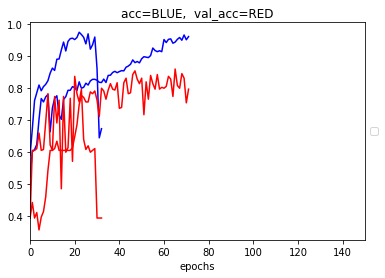

No handles with labels found to put in legend.


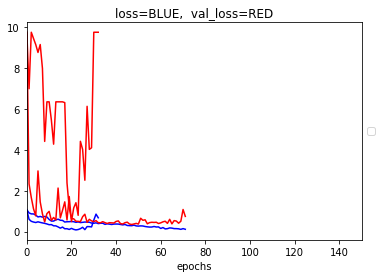

CURRENT Parameters---------------------------------------------------
repeat: 1
lr: 0.01
optimizer: <keras.optimizers.RMSprop object at 0x7fbd0f798b70>
batch_size: 32
base_layer: InceptionResNetV2_base
first_toplayer: GlobalAveragePooling2D()

Epoch 00025: ReduceLROnPlateau reducing learning rate to 0.008999999798834325.

Epoch 00031: ReduceLROnPlateau reducing learning rate to 0.008099999651312828.

Epoch 00037: ReduceLROnPlateau reducing learning rate to 0.007289999350905419.

Epoch 00043: ReduceLROnPlateau reducing learning rate to 0.006560999248176813.
Epoch 00043: early stopping
CURRENT Parameters---------------------------------------------------
repeat: 2
lr: 0.01
optimizer: <keras.optimizers.RMSprop object at 0x7fbc6de615f8>
batch_size: 32
base_layer: InceptionResNetV2_base
first_toplayer: GlobalAveragePooling2D()

Epoch 00007: ReduceLROnPlateau reducing learning rate to 0.008999999798834325.

Epoch 00013: ReduceLROnPlateau reducing learning rate to 0.008099999651312828.

Epoch

No handles with labels found to put in legend.


Epoch 00055: early stopping




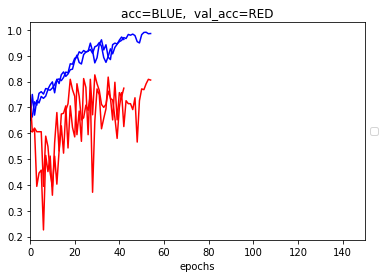

No handles with labels found to put in legend.


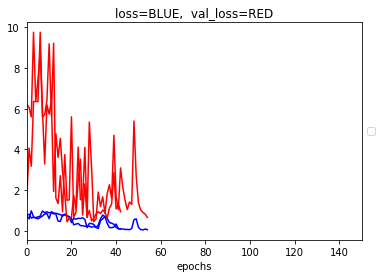

CURRENT Parameters---------------------------------------------------
repeat: 1
lr: 0.01
optimizer: <keras.optimizers.RMSprop object at 0x7fbc8c4ba940>
batch_size: 64
base_layer: InceptionResNetV2_base
first_toplayer: GlobalAveragePooling2D()

Epoch 00007: ReduceLROnPlateau reducing learning rate to 0.008999999798834325.

Epoch 00013: ReduceLROnPlateau reducing learning rate to 0.008099999651312828.

Epoch 00019: ReduceLROnPlateau reducing learning rate to 0.007289999350905419.

Epoch 00025: ReduceLROnPlateau reducing learning rate to 0.006560999248176813.
Epoch 00025: early stopping
CURRENT Parameters---------------------------------------------------
repeat: 2
lr: 0.01
optimizer: <keras.optimizers.RMSprop object at 0x7fbc77ac99e8>
batch_size: 64
base_layer: InceptionResNetV2_base
first_toplayer: GlobalAveragePooling2D()

Epoch 00007: ReduceLROnPlateau reducing learning rate to 0.008999999798834325.

Epoch 00013: ReduceLROnPlateau reducing learning rate to 0.008099999651312828.

Epoch

No handles with labels found to put in legend.


Epoch 00046: early stopping




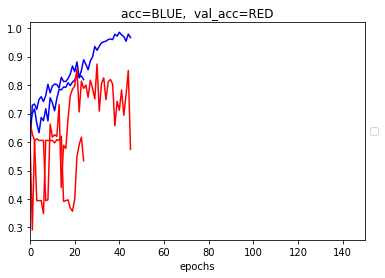

No handles with labels found to put in legend.


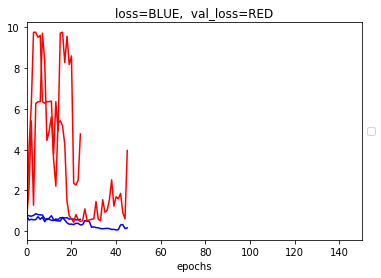

CURRENT Parameters---------------------------------------------------
repeat: 1
lr: 0.001
optimizer: <keras.optimizers.Adam object at 0x7fbcc2365320>
batch_size: 32
base_layer: InceptionResNetV2_base
first_toplayer: GlobalAveragePooling2D()

Epoch 00021: ReduceLROnPlateau reducing learning rate to 0.0009000000427477062.

Epoch 00027: ReduceLROnPlateau reducing learning rate to 0.0008100000384729356.

Epoch 00033: ReduceLROnPlateau reducing learning rate to 0.0007290000503417104.

Epoch 00039: ReduceLROnPlateau reducing learning rate to 0.0006561000715009868.
Epoch 00039: early stopping
CURRENT Parameters---------------------------------------------------
repeat: 2
lr: 0.001
optimizer: <keras.optimizers.Adam object at 0x7fbc8faaf278>
batch_size: 32
base_layer: InceptionResNetV2_base
first_toplayer: GlobalAveragePooling2D()

Epoch 00013: ReduceLROnPlateau reducing learning rate to 0.0009000000427477062.

Epoch 00019: ReduceLROnPlateau reducing learning rate to 0.0008100000384729356.

Epo

No handles with labels found to put in legend.


Epoch 00031: early stopping




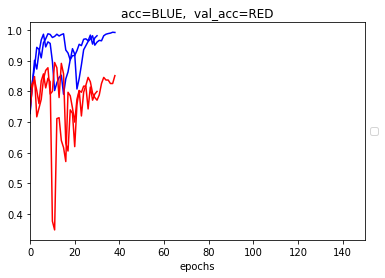

No handles with labels found to put in legend.


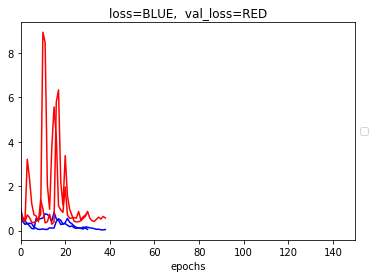

CURRENT Parameters---------------------------------------------------
repeat: 1
lr: 0.001
optimizer: <keras.optimizers.Adam object at 0x7fbcc2315630>
batch_size: 64
base_layer: InceptionResNetV2_base
first_toplayer: GlobalAveragePooling2D()

Epoch 00013: ReduceLROnPlateau reducing learning rate to 0.0009000000427477062.

Epoch 00019: ReduceLROnPlateau reducing learning rate to 0.0008100000384729356.

Epoch 00025: ReduceLROnPlateau reducing learning rate to 0.0007290000503417104.

Epoch 00031: ReduceLROnPlateau reducing learning rate to 0.0006561000715009868.
Epoch 00031: early stopping
CURRENT Parameters---------------------------------------------------
repeat: 2
lr: 0.001
optimizer: <keras.optimizers.Adam object at 0x7fbc92ff3d30>
batch_size: 64
base_layer: InceptionResNetV2_base
first_toplayer: GlobalAveragePooling2D()

Epoch 00014: ReduceLROnPlateau reducing learning rate to 0.0009000000427477062.

Epoch 00020: ReduceLROnPlateau reducing learning rate to 0.0008100000384729356.

Epo

No handles with labels found to put in legend.


Epoch 00032: early stopping




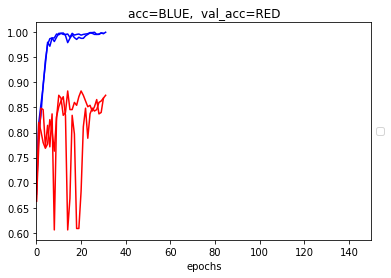

No handles with labels found to put in legend.


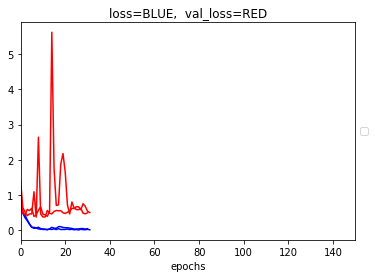

CURRENT Parameters---------------------------------------------------
repeat: 1
lr: 0.001
optimizer: <keras.optimizers.RMSprop object at 0x7fbc68306ac8>
batch_size: 32
base_layer: InceptionResNetV2_base
first_toplayer: GlobalAveragePooling2D()

Epoch 00007: ReduceLROnPlateau reducing learning rate to 0.0009000000427477062.

Epoch 00013: ReduceLROnPlateau reducing learning rate to 0.0008100000384729356.

Epoch 00029: ReduceLROnPlateau reducing learning rate to 0.0007290000503417104.

Epoch 00035: ReduceLROnPlateau reducing learning rate to 0.0006561000715009868.

Epoch 00041: ReduceLROnPlateau reducing learning rate to 0.0005904900433961303.

Epoch 00047: ReduceLROnPlateau reducing learning rate to 0.0005314410547725857.
Epoch 00047: early stopping
CURRENT Parameters---------------------------------------------------
repeat: 2
lr: 0.001
optimizer: <keras.optimizers.RMSprop object at 0x7fbc9b1bf278>
batch_size: 32
base_layer: InceptionResNetV2_base
first_toplayer: GlobalAveragePooling2D(

No handles with labels found to put in legend.


Epoch 00042: early stopping




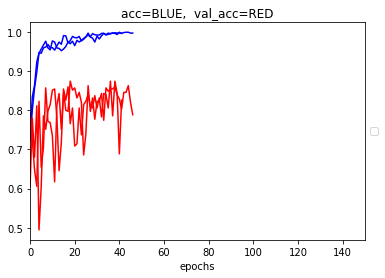

No handles with labels found to put in legend.


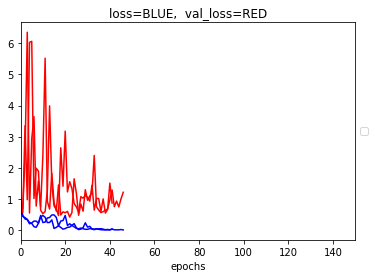

CURRENT Parameters---------------------------------------------------
repeat: 1
lr: 0.001
optimizer: <keras.optimizers.RMSprop object at 0x7fbc938f6438>
batch_size: 64
base_layer: InceptionResNetV2_base
first_toplayer: GlobalAveragePooling2D()

Epoch 00008: ReduceLROnPlateau reducing learning rate to 0.0009000000427477062.

Epoch 00014: ReduceLROnPlateau reducing learning rate to 0.0008100000384729356.

Epoch 00020: ReduceLROnPlateau reducing learning rate to 0.0007290000503417104.

Epoch 00026: ReduceLROnPlateau reducing learning rate to 0.0006561000715009868.
Epoch 00026: early stopping
CURRENT Parameters---------------------------------------------------
repeat: 2
lr: 0.001
optimizer: <keras.optimizers.RMSprop object at 0x7fbc99edc9e8>
batch_size: 64
base_layer: InceptionResNetV2_base
first_toplayer: GlobalAveragePooling2D()

Epoch 00015: ReduceLROnPlateau reducing learning rate to 0.0009000000427477062.

Epoch 00021: ReduceLROnPlateau reducing learning rate to 0.0008100000384729356

No handles with labels found to put in legend.


Epoch 00033: early stopping




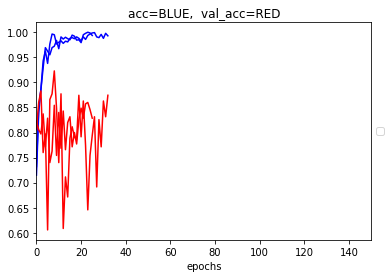

No handles with labels found to put in legend.


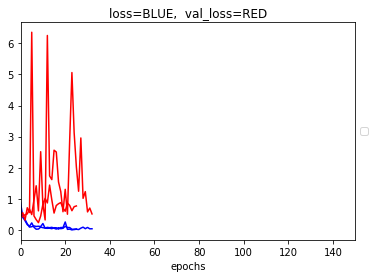

metrics_reported Index(['val_loss', 'val_acc', 'loss', 'acc', 'lr'], dtype='object')


In [34]:
#set verbose=1 to watch the model working (at model.fit() and modelcheckpoint) 
img_width, img_height = 96, 96  # IRNV2 is optimized for 299x299 images!

# Hyperparameter
epochs = 150  
patience_reduce_lr = 6 # 2 
patience_es = 24 # 4

# batch_size_candidates = [32] # is good
batch_size_candidates = [32, 64]
# batch_size_candidates = [16, 32, 64]

# optimizer_candidates = ['RMSprop(lr=lr)'] # is good
optimizer_candidates = ['Adam(lr=lr)', 'RMSprop(lr=lr)']
# optimizer_candidates = ['RMSprop(lr=lr)', 'SGD(lr=lr, momentum=0.9, nesterov=True)']
# optimizer_candidates = ['Adam(lr=lr)', 'RMSprop(lr=lr)', 'SGD(lr=lr, momentum=0.9)', 'SGD(lr=lr, momentum=0.9, nesterov=True)'] #Adagrad, SGD(lr=lr)

# lr_candidates = [1e-3] # is good
lr_candidates = [1e-2, 1e-3]
# lr_candidates = [1e-2, 1e-3, 1e-4]

# base_layer_candidates = ['Standard_base']
base_layer_candidates = ['Standard_base', 'InceptionResNetV2_base']

# first_toplayer_candidates=['GlobalAveragePooling2D()'] # delivers the best accuracy and produces smaller .h5 files when saving model 
first_toplayer_candidates = ['Flatten()', 'GlobalAveragePooling2D()'] 

# repeats=[1]
repeats=[1, 2] 
# repeats=[1, 2, 3]

# create the "logs" folder
if not os.path.exists('logs'):
    os.makedirs('logs') 

# Repeated Training/ Gridsearch
history_list = []

for first_toplayer in first_toplayer_candidates:
    
    for base_layer in base_layer_candidates:  

        for lr in lr_candidates:  
            
            for optimizer in optimizer_candidates:

                for batch_size in batch_size_candidates:                    

                    history_list2 = [] # must be [] before every reapeat-loop/round
                    
                    for repeat in repeats:
                        
                        # Tensorbord-data: create a new folder for every hyperparameter-variation and repeat
                        log_dir =os.path.join('./logs/', str(base_layer) + ' lr:'+str(lr)+' opt:'+str(optimizer)+' bs:'+str(batch_size)+' 1.TopL:'+str(first_toplayer)+' rep'+str(repeat))
                                              
                        print("CURRENT Parameters---------------------------------------------------")
                        print("repeat:", repeat)
                        print("lr:", lr)
                        # eval() method runs the code which is passed as an argument
                        print("optimizer:", eval(optimizer))
                        print("batch_size:", batch_size)
                        print("base_layer:", base_layer)  
                        print("first_toplayer:", first_toplayer)
                         

                        # CLEAR:
                        K.clear_session()
                        
                        
                        # INPUT_layer
                        input_layer = Input(shape=(img_width, img_height, 3), name="input_image")
                        
                        
                        # BASE_layers option: 'Standard_base'
                        if base_layer == 'Standard_base':
                            
                            x = Conv2D(filters=32, kernel_size=3, padding="same")(input_layer)
                            x = BatchNormalization()(x)
                            x = Activation("relu")(x)
                            x = Conv2D(filters=32, kernel_size=3, padding="same")(x)
                            x = BatchNormalization()(x)
                            x = Activation("relu")(x)
                            x = MaxPooling2D()(x)
                            x = Dropout(rate=0.2)(x)

                            x = Conv2D(filters=64, kernel_size=3, padding="same")(x)
                            x = BatchNormalization()(x)
                            x = Activation("relu")(x)
                            x = Conv2D(filters=64, kernel_size=3, padding="same")(x)
                            x = BatchNormalization()(x)
                            x = Activation("relu")(x)
                            x = MaxPooling2D()(x)
                            x = Dropout(rate=0.2)(x)

                            x = Conv2D(filters=128, kernel_size=3, padding="same")(x) 
                            x = BatchNormalization()(x)
                            x = Activation("relu")(x)
                            x = Conv2D(filters=128, kernel_size=3, padding="same")(x) 
                            x = BatchNormalization()(x)
                            x = Activation("relu")(x)
                            x = MaxPooling2D()(x)
                            x = Dropout(rate=0.2)(x)   
                        
                        # BASE_layers option: 'InceptionResNetV2_base'                                                
                        if base_layer == 'InceptionResNetV2_base':

                            base_model = InceptionResNetV2(include_top=False, weights="imagenet", input_tensor=input_layer)                                      

                            # trainable weights?
                            # for problems like catsVSdogs  trainable=False is OK, because model/weights were trained w. cats, dogs among the 80 categories)
                            # for cancer-pics we have to train model/weights again, trainable = True

                            base_model.trainable = True #default:True 
                            x = base_model.output

                 
                        # TOP_layers option: "GlobalAveragePooling2D()":                         
                        if first_toplayer == 'GlobalAveragePooling2D()':
                            
                            x = GlobalAveragePooling2D()(x)
                            x = Dense(2, name="output")(x) 
                            predictions = Activation('softmax')(x)
                            
                        # TOP_layers option: "Flatten()"
                        if first_toplayer == 'Flatten()':
                        
                            x = Flatten()(x) # Flatten()(better if you have lots of Data)or GlobalAveragePooling2D()(x)                                        
                            x = Dense(256, name="features")(x) # fetch embeddings_info here 
                            x = BatchNormalization()(x) 
                            x = Activation('relu')(x)
                            x = Dropout(rate=0.2)(x)
                            x = Dense(2, name="output")(x) # or fetch embeddings_info here 
                            predictions = Activation('softmax')(x)                         
                                           

                        # Model-inputs, -outputs:
                        model = Model(inputs=input_layer, outputs=predictions)
                                                
                        # COMPILE: 
                        # eval() method runs the code (which is passed as an argument)
                        model.compile(loss="categorical_crossentropy", optimizer=eval(optimizer), metrics=["accuracy"])
                                                
                        #print("get_config:", model.optimizer.get_config())
                                                

                        # CALLBACKS:                        
                        # val_loss is most important indicator! If val_loss drops, then val_acc increases automatically(statistically)
                                                

                        # CSV-LOGGER:
                        # saves all epochs w. loss & accuracy
                        
                        csv_clb = CSVLogger("./logs/log.csv")


                        # MODEL-CHECKPOINT:
                        # opt1: if you chose a concrete name e.g. cancermodel.h5 the file will be overwritten everytime the model improves
                        # mc_clb = ModelCheckpoint(filepath="./logs/cancermodel.h5",

                        # opt2. creates new file after every loss-improvement and set t. parameters as filename,{val_acc:.4f}= 4digits after t. point
                        mc_clb = ModelCheckpoint(filepath="./logs/model.val_loss{val_loss:.4f}-val_acc{val_acc:.4f}-epoch{epoch:02d}"+ str(base_layer)+' lr:'+str(lr)+' opt:'+str(optimizer)+' bs:'+str(batch_size)+' 1.TopL:'+str(first_toplayer)+' rep'+str(repeat)+".h5",
                                                    monitor="val_loss", # ='val_acc',
                                                    mode="min", # checks f. sinkinking loss
                                                    verbose=0,                                                    
                                                    save_best_only=True,  # True: saves only after loss-improvement, False: saves all
                                                    save_weights_only=False) # saves the whole model                        
                                          

                        # LR_SCHEDULER(optional):
                        # if you have an idea of the right LR
                        # lr_clb = LearningRateScheduler(lr_schedule)


                        # REDUCE-LR-ON-PLATEAU: 
                        reduce_lr_clb = ReduceLROnPlateau(
                                        monitor="val_loss", 
                                        factor=0.9, # 0.95
                                        verbose=1, 
                                        patience=patience_reduce_lr) 
                        
                        # EARLYSTOPPING:
                        # stopps training if loss doesn't improve after n epochs of patience
                        es_clb = EarlyStopping(monitor="val_loss",
                                               patience=patience_es, 
                                               mode="min", # checks f. sinkinking loss
                                               verbose=1)


                        #TENSORBOARD:                        
                        #saves labels as csv file to show embeddings                        
                        with open("./logs/metadata.tsv", "w") as f:
                            np.savetxt(f, y_test_cat.astype(int)[:100]) # more than 1000 are confusing!

                        tb = TensorBoard(log_dir=log_dir, # ="./logs",
                                         histogram_freq = 0, # !!SLOW training if >=1 and many layers 
                                         batch_size=batch_size, # 32
                                         write_graph=True,
                                         write_images=True,
                                         embeddings_freq=1,
                                         embeddings_data=x_test[:100], # more than 1000 are confusing
                                         embeddings_layer_names="output",
                                         embeddings_metadata="metadata.tsv" 
                                         ) 

                        # FIT                                              
                        h = model.fit(x_train, y_train_cat, 
                                           epochs=epochs,
                                           batch_size=batch_size, 
                                           validation_split=0.2, # validation_data=[x_test, y_test_cat],
                                           verbose = 0, # verbose = 0
                                           callbacks=[csv_clb, mc_clb, reduce_lr_clb, es_clb, tb]) #tb
                        # model.summary() #is very long for IRNV2

                        
                        #PLOT / MODEL COMPARISON loss & accuray

                        # print("h",h) 
                        # print("h.history",h.history)                         
                                                
                        # BIG COMPARISON/EVALUATION of ALL MODELS/versions (only repeat1)
                        # append history to history_list to create df with parameters after every iteration/run: 
                        
                        if repeat == 1:
                            history_list.append(pd.DataFrame(h.history, index=h.epoch))
                            #print("dflist", dflist) #GS: beginners
                        
                        # COMPARISON/EVALUATION of CURRENT model/hyperparamversion repeat1 and 2)
                        # append history to history_list2 to create df with parameters after every iteration/run: 
                        
                        history_list2.append(pd.DataFrame(h.history, index=h.epoch))
                        # print("history_list2", history_list2) 
                        
                        # show which metrics are reported 
                        metrics_reported2 = history_list2[0].columns
                        # print("metrics_reported2", metrics_reported2)                  

   
                    history_df2 = pd.concat(history_list2, axis=1)
                    # print("history_df2", history_df2)             

                    idx2 = pd.MultiIndex.from_product([repeats, metrics_reported2],
                             names=['repeat', 'metric'])
                    # print("idx2", idx2)               

                    history_df2.columns = idx2                    
                    # print("history_df2.columns", history_df2.columns)
                    # print("history_df", history_df)

                    # plt.figure(figsize=(5,5), dpi=100)
                    print("\n")
                    plt.plot(history_df2.xs('acc', axis=1, level='metric'), color="blue") 
                    plt.plot(history_df2.xs('val_acc', axis=1, level='metric'), color="red") 
                    plt.xlim(0, epochs)
                    plt.title("acc=BLUE,  val_acc=RED")
                    plt.xlabel("epochs")
                    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
                    plt.show()

                    # plt.figure(figsize=(5,5), dpi=100)
                    plt.plot(history_df2.xs('loss', axis=1, level='metric'), color="blue") # xlim=(0,15), ylim=(0.5,1),ylim=(0,2),
                    plt.plot(history_df2.xs('val_loss', axis=1, level='metric'), color="red") # xlim=(0,15)
                    plt.xlim(0, epochs)
                    plt.title("loss=BLUE,  val_loss=RED")
                    plt.xlabel("epochs")
                    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
                    plt.show()                   

                    
history_df = pd.concat(history_list, axis=1)
# print("history_df", history_df)

metrics_reported = history_list[0].columns
print("metrics_reported", metrics_reported)

#SUMMARY
# model.summary() #is very long for IRNV2
       

# Comparison & Visualisation

#### open Tensorboard for detailed comparison of many different models

In [35]:
# open Tensorbord on Linux systems:

# 1.open logs folder and copy the path 
# 2.open terminal/console and type: 
#   tensorboard --logdir="INSERT YOUR PATH HERE"
#   e.g. tensorboard --logdir="/home/george/desktop/projects/kaggle_cancer/logs"
#   output looks like:
#   TensorBoard 1.14.0 at http://name of my computer:1234/ (Press CTRL+C to quit)
# 3.copy the URL w. right mouseclick, !!!ATTENTION:Strg C ends tensorboard!!
# 4.open the URL in a browser
# 5.choose a model or press "TOGGLE ALL RUNS" to display all models/runs


In [36]:
repeats=[1] #for repeat Nr 1 - delete to display all repeats

idx = pd.MultiIndex.from_product([first_toplayer_candidates, base_layer_candidates, lr_candidates, optimizer_candidates, batch_size_candidates, repeats, metrics_reported],
                     names=['first_toplayer_candidates', 'base_layer_candidates', 'lr_candidates', 'optimizer_candidates', 'batch_size_candidates', 'repeats', 'metric']) 

history_df.columns = idx

In [37]:
#Pandas display Full Content (no truncation)

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', -1)

history_df

first_toplayer_candidates     Flatten()                                \
base_layer_candidates     Standard_base                                 
lr_candidates                     0.010                                 
optimizer_candidates        Adam(lr=lr)                                 
batch_size_candidates                32                                 
repeats                               1                                 
metric                         val_loss   val_acc      loss       acc   
0                          0.884249      0.668571  0.895485  0.685714   
1                          0.485554      0.785714  0.524290  0.771429   
2                          0.679255      0.591429  0.490739  0.797143   
3                          0.544519      0.748571  0.477335  0.786429   
4                          0.638411      0.680000  0.436821  0.814286   
5                          0.626555      0.640000  0.432936  0.810714   
6                          0.461657      0.782857  0.405320  0.829286   
7                          0.724056      0.617143  0.379925  0.846429   
8                          0.486669      0.771429  0.400184  0.820714   
9                          0.384537      0.848571  0.380927  0.839286   
10                         0.465617      0.785714  0.380864  0.840714   
11                         0.519557      0.745714  0.339113  0.854286   
12                         0.574355      0.737143  0.351901  0.848571   
13                         0.532317      0.748571  0.322137  0.875000   
14                         0.472625      0.771429  0.301775  0.877857   
15                         0.413851      0.822857  0.291967  0.878571   
16                         0.628345      0.728571  0.256548  0.901429   
17                         0.445169      0.831429  0.241310  0.911429   
18                         0.492643      0.788571  0.198065  0.924286   
19                         0.553868      0.822857  0.191248  0.927857   
20                         0.566081      0.797143  0.225229  0.918571   
21                         0.462010      0.825714  0.165444  0.933571   
22                         0.540204      0.820000  0.159882  0.939286   
23                         0.566307      0.780000  0.166872  0.940714   
24                         0.579039      0.794286  0.108674  0.960714   
25                         0.628749      0.822857  0.084967  0.967857   
26                         0.831434      0.768571  0.110260  0.963571   
27                         0.559278      0.825714  0.077115  0.971429   
28                         1.687035      0.720000  0.080708  0.973571   
29                         0.678174      0.808571  0.079112  0.972143   
30                         0.990767      0.820000  0.068034  0.977143   
31                         0.728938      0.822857  0.055786  0.980714   
32                         0.658440      0.831429  0.035474  0.985714   
33                         0.774399      0.820000  0.031057  0.986429   
34                        NaN           NaN       NaN       NaN         
35                        NaN           NaN       NaN       NaN         
36                        NaN           NaN       NaN       NaN         
37                        NaN           NaN       NaN       NaN         
38                        NaN           NaN       NaN       NaN         
39                        NaN           NaN       NaN       NaN         
40                        NaN           NaN       NaN       NaN         
41                        NaN           NaN       NaN       NaN         
42                        NaN           NaN       NaN       NaN         
43                        NaN           NaN       NaN       NaN         
44                        NaN           NaN       NaN       NaN         
45                        NaN           NaN       NaN       NaN         
46                        NaN           NaN       NaN       NaN         
47                        NaN           NaN       NaN     

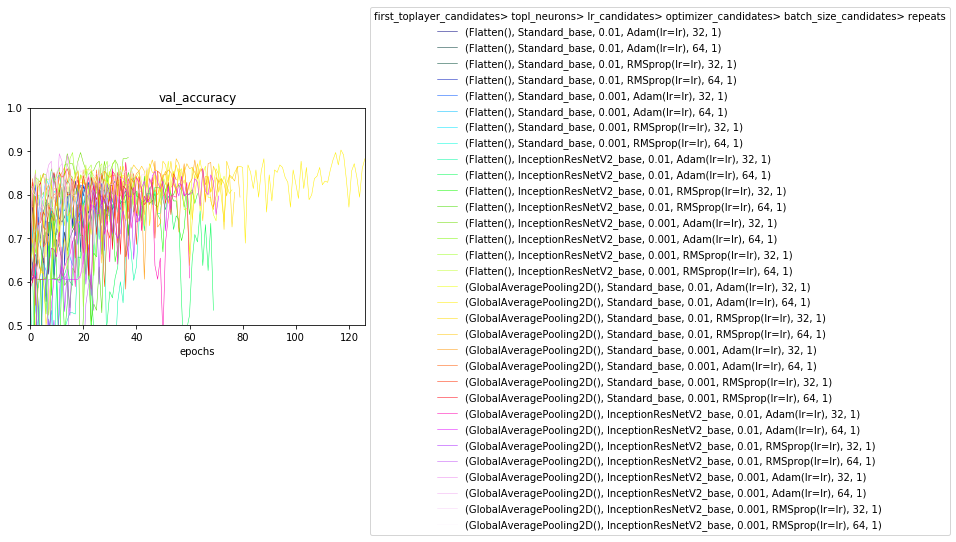

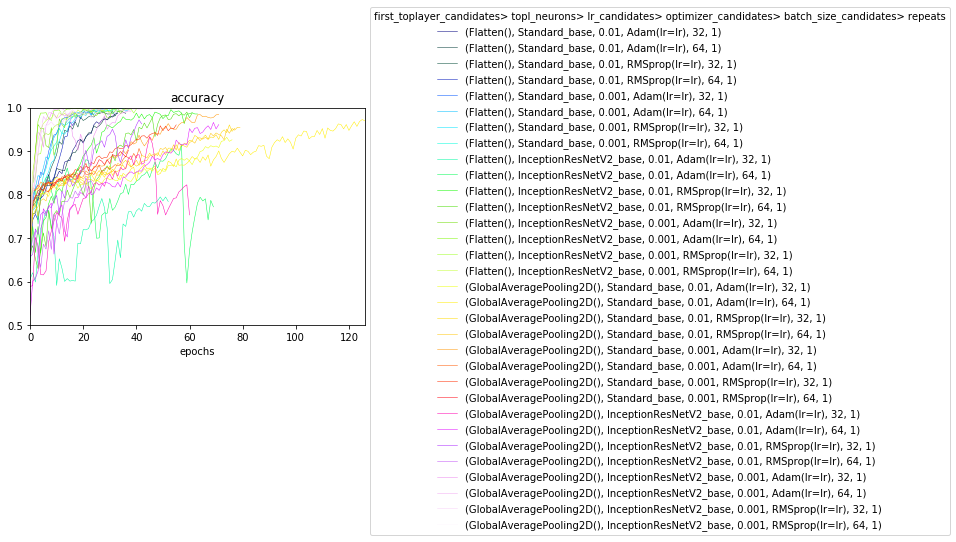

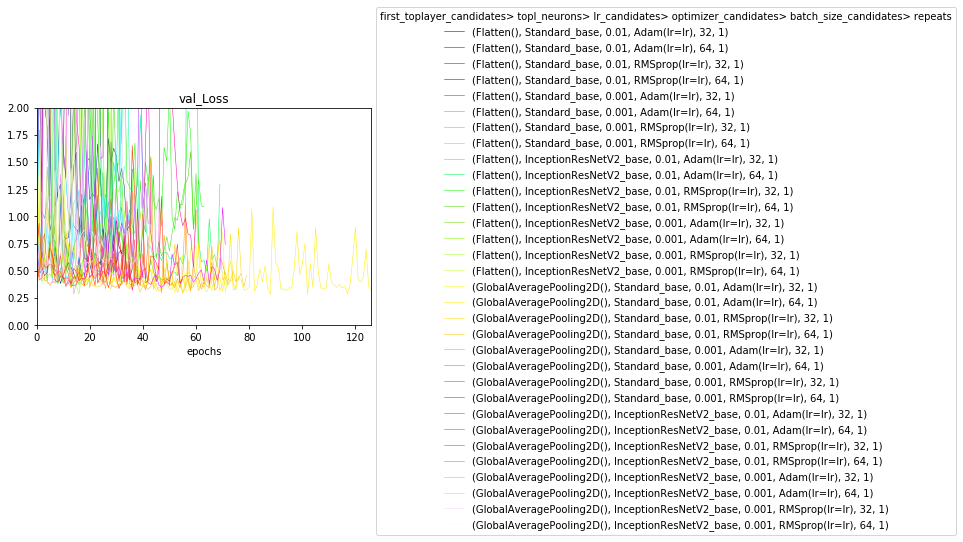

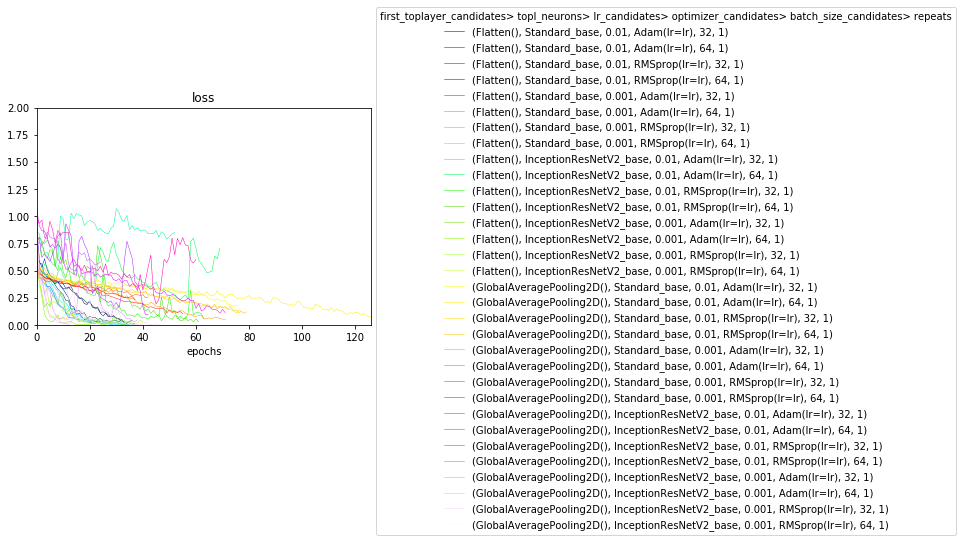

In [38]:
# Overview of all-modelversions  - OPEN TENSORBORD for better comparison if you have many models

# plt.figure(figsize=(30,30), dpi=300) 

history_df.xs('val_acc', axis=1, level='metric').plot(ylim=(0.5,1), linewidth=0.5, cmap = "gist_ncar") #linewidth=1, xlim=(0,15)
plt.title("val_accuracy")
plt.xlabel("epochs")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.25), title="first_toplayer_candidates> topl_neurons> lr_candidates> optimizer_candidates> batch_size_candidates> repeats")
plt.savefig('val_accuracy.png', bbox_inches="tight", pad_inches=1, dpi=300) #save plot
plt.show()

history_df.xs('acc', axis=1, level='metric').plot(ylim=(0.5,1), linewidth=0.5, cmap = "gist_ncar") #xlim=(0,15)
plt.title("accuracy")
plt.xlabel("epochs")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.25), title="first_toplayer_candidates> topl_neurons> lr_candidates> optimizer_candidates> batch_size_candidates> repeats")
plt.show()

history_df.xs('val_loss', axis=1, level='metric').plot(ylim=(0,2), linewidth=0.5 ,cmap = "gist_ncar") #color=red cmap = "prism", xlim=(0,15), 
plt.title("val_Loss")
plt.xlabel("epochs")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.25), title="first_toplayer_candidates> topl_neurons> lr_candidates> optimizer_candidates> batch_size_candidates> repeats")
plt.savefig('val_loss.png', bbox_inches="tight", pad_inches=1, dpi=300) #save plot
plt.show()

history_df.xs('loss', axis=1, level='metric').plot(ylim=(0,2), linewidth=0.5, cmap = "gist_ncar") #xlim=(0,15)
plt.title("loss")
plt.xlabel("epochs")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.25), title="first_toplayer_candidates> topl_neurons> lr_candidates> optimizer_candidates> batch_size_candidates> repeats")
plt.show()


# Top Ten Models

In [39]:
files=os.listdir("./logs")
#print(files)

h5files = [file for file in files if file[-3:] == ".h5"] #list of files that end with .h5
#print(h5files)
h5files.sort()
#print(h5files)

print("TOP TEN MODELS:")
print("\n")
for file in h5files[:10]:
    print(file)
    print("\n")
print("\n")


TOP TEN MODELS:


model.val_loss0.2342-val_acc0.9229-epoch09InceptionResNetV2_base lr:0.001 opt:RMSprop(lr=lr) bs:64 1.TopL:GlobalAveragePooling2D() rep2.h5


model.val_loss0.2694-val_acc0.8857-epoch60Standard_base lr:0.01 opt:RMSprop(lr=lr) bs:32 1.TopL:GlobalAveragePooling2D() rep2.h5


model.val_loss0.2696-val_acc0.8857-epoch35InceptionResNetV2_base lr:0.001 opt:Adam(lr=lr) bs:32 1.TopL:Flatten() rep2.h5


model.val_loss0.2738-val_acc0.8771-epoch52Standard_base lr:0.01 opt:RMSprop(lr=lr) bs:32 1.TopL:GlobalAveragePooling2D() rep2.h5


model.val_loss0.2835-val_acc0.8771-epoch103Standard_base lr:0.01 opt:Adam(lr=lr) bs:64 1.TopL:GlobalAveragePooling2D() rep1.h5


model.val_loss0.2850-val_acc0.8829-epoch89Standard_base lr:0.01 opt:Adam(lr=lr) bs:64 1.TopL:GlobalAveragePooling2D() rep1.h5


model.val_loss0.2861-val_acc0.8743-epoch73Standard_base lr:0.01 opt:Adam(lr=lr) bs:64 1.TopL:GlobalAveragePooling2D() rep2.h5


model.val_loss0.2866-val_acc0.8914-epoch15InceptionResNetV2_base lr:0.0

# Load Model

In [40]:
# LOAD the Nr.1

print("FIRST PLACE:", h5files[0])
model = load_model("./logs/" +h5files[0])

#or LOAD another model 
#model = load_model("./logs JSCH1_Flatten cat+dog 2020.02.14/model.val_loss0.1151-epoch44JSCH1 lr:0.01 opt:<class 'keras.optimizers.Adam'> bs:16 1.TopL:GlobalAveragePooling2D() tln:32 rep1.h5")

# SUMMARY
model.summary()


FIRST PLACE: model.val_loss0.2342-val_acc0.9229-epoch09InceptionResNetV2_base lr:0.001 opt:RMSprop(lr=lr) bs:64 1.TopL:GlobalAveragePooling2D() rep2.h5
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_image (InputLayer)        (None, 96, 96, 3)    0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 47, 47, 32)   864         input_image[0][0]                
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 47, 47, 32)   96          conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 47, 47, 32)   0  

# Evaluate, Confusion Matrix, Predicts Samples 

600/600 [==============================] - 5s 8ms/step
EVALUATE: accuracy on test-data:  0.835




Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


CONFUSION MATRIX:
Predicted  False  True  __all__
Actual                         
False      300    30    330    
True       69     201   270    
__all__    369    231   600    


label: negative = [0] = False  (np.argmax [negative] = np.argmax [1, 0]= 0 = False)
label: positive = [1] = True   (np.argmax [positive] = np.argmax [0, 1]= 1 = True)




image Nr: 0
prediction/How sure is model/prediction? -> probability(%) for [negative, positive] [[0.9948515  0.00514842]]
real-label: [1. 0.]


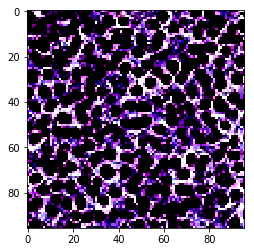

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


image Nr: 1
prediction/How sure is model/prediction? -> probability(%) for [negative, positive] [[0.98469526 0.01530473]]
real-label: [0. 1.]


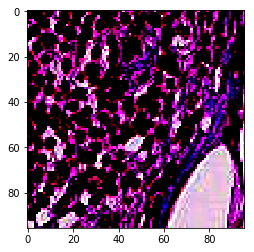

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


image Nr: 2
prediction/How sure is model/prediction? -> probability(%) for [negative, positive] [[0.97932947 0.02067051]]
real-label: [1. 0.]


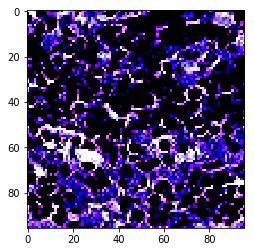

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


image Nr: 3
prediction/How sure is model/prediction? -> probability(%) for [negative, positive] [[7.462707e-04 9.992537e-01]]
real-label: [0. 1.]


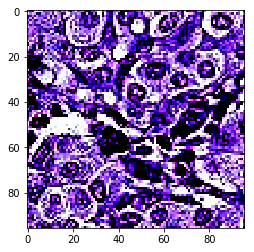

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


image Nr: 4
prediction/How sure is model/prediction? -> probability(%) for [negative, positive] [[0.32498643 0.6750136 ]]
real-label: [0. 1.]


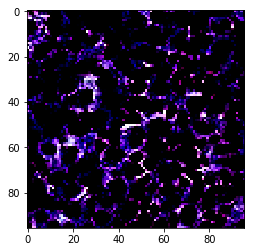

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


image Nr: 5
prediction/How sure is model/prediction? -> probability(%) for [negative, positive] [[0.95296156 0.04703844]]
real-label: [0. 1.]


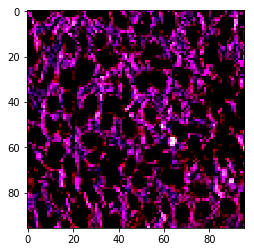

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


image Nr: 6
prediction/How sure is model/prediction? -> probability(%) for [negative, positive] [[0.00523777 0.99476224]]
real-label: [0. 1.]


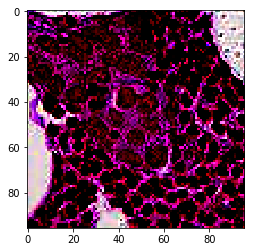

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


image Nr: 7
prediction/How sure is model/prediction? -> probability(%) for [negative, positive] [[1.0962967e-04 9.9989033e-01]]
real-label: [0. 1.]


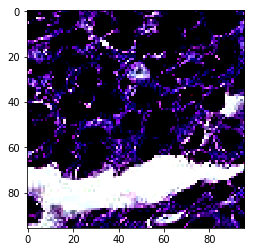

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


image Nr: 8
prediction/How sure is model/prediction? -> probability(%) for [negative, positive] [[0.05641797 0.943582  ]]
real-label: [0. 1.]


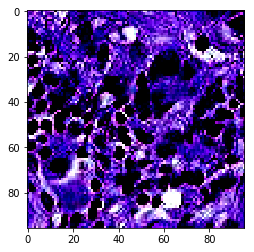

In [41]:
try:
    #Evaluate 
    score = model.evaluate(x_test, y_test_cat, batch_size=32) #128
    print("EVALUATE: accuracy on test-data: ", score[1]) #score[0]=loss
    print("\n")
    
    #Predict
    y_pred = model.predict(x_test)

    #CONFUSION MATRIX
    print("CONFUSION MATRIX:")
    print(ConfusionMatrix(np.argmax(y_test_cat, axis=1), np.argmax(y_pred, axis=1)))
    print("\n")
    print("label: negative = [0] = False  (np.argmax [negative] = np.argmax [1, 0]= 0 = False)" )
    print("label: positive = [1] = True   (np.argmax [positive] = np.argmax [0, 1]= 1 = True)" )
    print("\n")
    print("\n")
    
    #PREDICT
   
    #for sample in testsamples:
    for n in range(0,9):
        
        print("image Nr:", n)
        print("prediction/How sure is model/prediction? -> probability(%) for [negative, positive]", model.predict(x_test[n].reshape(1, img_width, img_height, 3)))
        print("real-label:", y_test_cat[n])
        plt.imshow(x_test[n])
        plt.show()       
           
except:
    pass